# 0. Install project dependencies

In [1]:
# install requires packages
! pip install numpy
! pip install pandas
! pip install matplotlib seaborn
! pip install pyspark
! pip install jupyter

In [2]:
import csv
from collections import defaultdict
from typing import List, Optional, Union, Tuple
from warnings import filterwarnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyspark
from pyspark.ml import Pipeline
from pyspark.ml.classification import (
    LogisticRegression,
    LinearSVC,
    DecisionTreeClassifier,
    GBTClassifier,
    RandomForestClassifier,

)
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import (
    StringIndexer,
    OneHotEncoder,
    VectorAssembler,
    StandardScaler,
    Normalizer,
)
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.sql import SparkSession, functions as F

filterwarnings(action="ignore")

---
# 1. Setup Apache Spark

In [3]:
conf = pyspark.SparkConf()
conf.setMaster(
        "local[*]"
)  # use the local standalone version of pyspark that is installed

conf.setAppName("income_classification")  # set the name of the application
conf.set("spark.authenticate", False)  # disable authentication
conf.set(
        "spark.dynamicAllocation.enabled", True
)  # enable dynamic allocation to avoid out-of-memory errors

spark_cx = pyspark.SparkContext(conf=conf)
spark_cx.setLogLevel("ERROR")

spark_session = SparkSession(
        spark_cx
)  # create a spark session using the available spark context object

# show some info about the active spark session
spark_session.getActiveSession()

22/10/16 15:09:53 WARN Utils: Your hostname, legion-7 resolves to a loopback address: 127.0.1.1; using 192.168.0.4 instead (on interface wlp0s20f3)
22/10/16 15:09:53 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/10/16 15:10:01 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


---
# 2. Create a Spark DataFrame

In [4]:
def print_dataframe_basic_info(df_in: pyspark.sql.DataFrame) -> None:
    instances_count = df_in.count()

    print(f"Number of instances: {instances_count}")
    print(f"Number of features: {len(df_in.columns)}")

In [5]:
train_data_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
test_data_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test"

columns = ["age", "workclass", "fnlwgt", "education", "education-num", "marital-status", "occupation", "relationship",
           "race",
           "sex", "capital-gain", "capital-loss", "hours-per-week", "native-country", "income", ]

# set this to `False` if the dataset already exists in this directory
download = True

In [6]:
if download:
    ! wget "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
    ! wget "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test"

--2022-10-16 15:10:03--  https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3974305 (3.8M) [application/x-httpd-php]
Saving to: ‘adult.data’

adult.data          100%[===================>]   3.79M   441KB/s    in 14s     

2022-10-16 15:10:20 (282 KB/s) - ‘adult.data’ saved [3974305/3974305]

--2022-10-16 15:10:20--  https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2003153 (1.9M) [application/x-httpd-php]
Saving to: ‘adult.test’

adult.test          100%[===================>]   1.91M   427KB/s    in 4.6s    

2022-

In [7]:
df_train = spark_session.read.csv("adult.data", sep=",", encoding="utf-8", header=False, inferSchema=True, )
for old_col_name, new_col_name in zip(df_train.columns, columns):
    df_train = df_train.withColumnRenamed(old_col_name, new_col_name)

df_test = spark_cx.textFile("adult.test").mapPartitions(
        lambda line: csv.reader(line, delimiter=',', quotechar='"')
).filter(
        lambda
            line: len(line) >= 2
).toDF(columns)

In [8]:
df_train.show(1, vertical=True)

-RECORD 0------------------------
 age            | 39             
 workclass      |  State-gov     
 fnlwgt         | 77516.0        
 education      |  Bachelors     
 education-num  | 13.0           
 marital-status |  Never-married 
 occupation     |  Adm-clerical  
 relationship   |  Not-in-family 
 race           |  White         
 sex            |  Male          
 capital-gain   | 2174.0         
 capital-loss   | 0.0            
 hours-per-week | 40.0           
 native-country |  United-States 
 income         |  <=50K         
only showing top 1 row



In [9]:
df_test.show(1, vertical=True)

-RECORD 0----------------------------
 age            | 25                 
 workclass      |  Private           
 fnlwgt         |  226802            
 education      |  11th              
 education-num  |  7                 
 marital-status |  Never-married     
 occupation     |  Machine-op-inspct 
 relationship   |  Own-child         
 race           |  Black             
 sex            |  Male              
 capital-gain   |  0                 
 capital-loss   |  0                 
 hours-per-week |  40                
 native-country |  United-States     
 income         |  <=50K.            
only showing top 1 row



In [10]:
print_dataframe_basic_info(df_train)

Number of instances: 32561
Number of features: 15


In [11]:
print_dataframe_basic_info(df_test)

Number of instances: 16281
Number of features: 15


In [12]:
# strip column names and replace "-" with "_"
def modify_column_names(df_in: pyspark.sql.DataFrame) -> pyspark.sql.DataFrame:
    for col in df_in.columns:
        if " " in col or "-" in col:
            df_in = df_in.withColumnRenamed(col, col.strip().replace("-", "_"))

    return df_in


df_train = modify_column_names(df_train)
df_test = modify_column_names(df_test)

df_train.columns

['age',
 'workclass',
 'fnlwgt',
 'education',
 'education_num',
 'marital_status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'capital_gain',
 'capital_loss',
 'hours_per_week',
 'native_country',
 'income']

In [13]:
df_train.printSchema()

root
 |-- age: integer (nullable = true)
 |-- workclass: string (nullable = true)
 |-- fnlwgt: double (nullable = true)
 |-- education: string (nullable = true)
 |-- education_num: double (nullable = true)
 |-- marital_status: string (nullable = true)
 |-- occupation: string (nullable = true)
 |-- relationship: string (nullable = true)
 |-- race: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- capital_gain: double (nullable = true)
 |-- capital_loss: double (nullable = true)
 |-- hours_per_week: double (nullable = true)
 |-- native_country: string (nullable = true)
 |-- income: string (nullable = true)



In [14]:
df_test.printSchema()

root
 |-- age: string (nullable = true)
 |-- workclass: string (nullable = true)
 |-- fnlwgt: string (nullable = true)
 |-- education: string (nullable = true)
 |-- education_num: string (nullable = true)
 |-- marital_status: string (nullable = true)
 |-- occupation: string (nullable = true)
 |-- relationship: string (nullable = true)
 |-- race: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- capital_gain: string (nullable = true)
 |-- capital_loss: string (nullable = true)
 |-- hours_per_week: string (nullable = true)
 |-- native_country: string (nullable = true)
 |-- income: string (nullable = true)



In [15]:
df_train = df_train.withColumn("is_train", F.lit(1))
df_test = df_test.withColumn("is_train", F.lit(0))

In [16]:
numerical_columns = [
    "age",
    "fnlwgt",
    "education_num",
    "capital_gain",
    "capital_loss",
    "hours_per_week",
]
non_numerical_columns = [
    "workclass",
    "education",
    "marital_status",
    "occupation",
    "relationship",
    "race",
    "native_country",
    "income",
]

In [17]:
# cast numerical columns of `df_test` dataframe from string to integer
for col_name in df_test.columns:
    df_test = df_test.withColumn(
            col_name, F.col(col_name).cast("int") if col_name in numerical_columns else F.col(col_name)
    )

df_test.printSchema()

root
 |-- age: integer (nullable = true)
 |-- workclass: string (nullable = true)
 |-- fnlwgt: integer (nullable = true)
 |-- education: string (nullable = true)
 |-- education_num: integer (nullable = true)
 |-- marital_status: string (nullable = true)
 |-- occupation: string (nullable = true)
 |-- relationship: string (nullable = true)
 |-- race: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- capital_gain: integer (nullable = true)
 |-- capital_loss: integer (nullable = true)
 |-- hours_per_week: integer (nullable = true)
 |-- native_country: string (nullable = true)
 |-- income: string (nullable = true)
 |-- is_train: integer (nullable = false)



In [18]:
df = df_train.union(df_test)
print_dataframe_basic_info(df)

Number of instances: 48842
Number of features: 16


In [19]:
df.columns

['age',
 'workclass',
 'fnlwgt',
 'education',
 'education_num',
 'marital_status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'capital_gain',
 'capital_loss',
 'hours_per_week',
 'native_country',
 'income',
 'is_train']

In [20]:
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- workclass: string (nullable = true)
 |-- fnlwgt: double (nullable = true)
 |-- education: string (nullable = true)
 |-- education_num: double (nullable = true)
 |-- marital_status: string (nullable = true)
 |-- occupation: string (nullable = true)
 |-- relationship: string (nullable = true)
 |-- race: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- capital_gain: double (nullable = true)
 |-- capital_loss: double (nullable = true)
 |-- hours_per_week: double (nullable = true)
 |-- native_country: string (nullable = true)
 |-- income: string (nullable = true)
 |-- is_train: integer (nullable = false)



In [21]:
def describe_pd(
        df_in: pyspark.sql.DataFrame,
        columns: List[str],
        deciles=False,
):
    if deciles:
        percentiles = np.array(range(0, 110, 10))
    else:
        percentiles = [25, 50, 75]

    percs = np.transpose(
            [np.percentile(df_in.select(x).collect(), percentiles) for x in columns]
    )
    percs = pd.DataFrame(percs, columns=columns)
    percs["summary"] = [str(p) + "%" for p in percentiles]

    spark_describe = df_in.describe().toPandas()
    new_df = pd.concat([spark_describe, percs], ignore_index=True)
    new_df = new_df.round(2)
    return new_df[["summary"] + columns]

In [22]:
# show a summary description of the numerical columns
describe_pd(df, numerical_columns)

,summary,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week
0,count,48842,48842,48842,48842,48842,48842
1,mean,38.64358543876172,189664.13459727284,10.078088530363212,1079.0676262233324,87.50231358257237,40.422382375824085
2,stddev,13.710509934443568,105604.0254231573,2.5709727555922615,7452.019057655406,403.00455212436043,12.391444024252305
3,min,17,12285.0,1.0,0.0,0.0,1.0
4,max,90,1490400.0,16.0,99999.0,4356.0,99.0
5,25%,28.0,117550.5,9.0,0.0,0.0,40.0
6,50%,37.0,178144.5,10.0,0.0,0.0,40.0
7,75%,48.0,237642.0,12.0,0.0,0.0,45.0


---
# 3. Cleaning Data

In [23]:
def print_or_get_column_distinct_values(
        df_in: pyspark.sql.DataFrame,
        column_name: str,
        sort_by_count: bool = False,
        ascending: bool = False,
        number_of_rows: int = 100,
        print_results: bool = True,
) -> Optional[pyspark.sql.DataFrame]:
    df_in = (
        df_in.select(column_name)
        .groupBy(column_name)
        .agg(F.count(column_name).alias("Count"))
    )
    df_in = (
        df_in.sort("Count", ascending=ascending)
        if sort_by_count
        else df_in.sort(column_name, ascending=ascending)
    )

    return df_in.show(number_of_rows, truncate=False) if print_results else df_in

In [24]:
def column_distinct_values_count(
        df_in: pyspark.sql.DataFrame,
        column_name: str,
) -> int:
    return (
        df_in.select(column_name)
        .groupBy(column_name)
        .agg(F.count(column_name).alias("Count"))
        .count()
    )

In [25]:
def show_null_values_count(
        df_in: pyspark.sql.DataFrame,
        column_names: Union[str, List[str]] = None,
) -> None:
    if column_names is None:
        column_names = df_in.columns
    else:
        if isinstance(column_names, str):
            column_names = [column_names]

    df_in.select(
            [
                F.count(F.when(F.isnan(c) | F.col(c).isNull(), c)).alias(c)
                for c in column_names
            ]
    ).show(vertical=True)

In [26]:
def replace_value_with_null(
        df_in: pyspark.sql.DataFrame,
        value,
        column_names: Union[str, List[str]] = None,
) -> pyspark.sql.DataFrame:
    if column_names is None:
        column_names = df_in.columns
    else:
        if isinstance(column_names, str):
            column_names = [column_names]

    return df_in.select(
            [
                F.when(F.col(col_name) == value, None)
                .otherwise(F.col(col_name))
                .alias(col_name)
                if col_name in column_names
                else F.col(col_name)
                for col_name in df.columns
            ]
    )

In [27]:
def strip_values_in_the_dataframe(
        df_in: pyspark.sql.DataFrame, column_names: Union[str, List[str]] = None
) -> pyspark.sql.DataFrame:
    if column_names is None:
        column_names = df_in.columns
    elif isinstance(column_names, str):
        column_names = [column_names]

    return df_in.select(
            [
                F.trim(col_name).alias(col_name)
                if col_name in column_names
                else F.col(col_name)
                for col_name in df_in.columns
            ]
    )

In [28]:
show_null_values_count(df)

-RECORD 0-------------
 age            | 0   
 workclass      | 0   
 fnlwgt         | 0   
 education      | 0   
 education_num  | 0   
 marital_status | 0   
 occupation     | 0   
 relationship   | 0   
 race           | 0   
 sex            | 0   
 capital_gain   | 0   
 capital_loss   | 0   
 hours_per_week | 0   
 native_country | 0   
 income         | 0   
 is_train       | 0   



Above output shows that there are no null values in the dataframe, but, based on the dataset description, `null`
values are marked with `?`. However, it is better to strip non-numerical column values before replacing the `?` with
`null` in the dataframe.

In [29]:
# strip row values to remove extra spaces at both ends of values
df = strip_values_in_the_dataframe(df, non_numerical_columns)

In [30]:
# replace all `?` values in the dataframe with `null`
df = replace_value_with_null(df, "?", column_names=non_numerical_columns)

In [31]:
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- workclass: string (nullable = true)
 |-- fnlwgt: double (nullable = true)
 |-- education: string (nullable = true)
 |-- education_num: double (nullable = true)
 |-- marital_status: string (nullable = true)
 |-- occupation: string (nullable = true)
 |-- relationship: string (nullable = true)
 |-- race: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- capital_gain: double (nullable = true)
 |-- capital_loss: double (nullable = true)
 |-- hours_per_week: double (nullable = true)
 |-- native_country: string (nullable = true)
 |-- income: string (nullable = true)
 |-- is_train: integer (nullable = false)



Because I only replaced `?` in non-numerical columns, data type of numerical columns did not change during the
operation.

In [32]:
show_null_values_count(df)

-RECORD 0--------------
 age            | 0    
 workclass      | 2799 
 fnlwgt         | 0    
 education      | 0    
 education_num  | 0    
 marital_status | 0    
 occupation     | 2809 
 relationship   | 0    
 race           | 0    
 sex            | 0    
 capital_gain   | 0    
 capital_loss   | 0    
 hours_per_week | 0    
 native_country | 857  
 income         | 0    
 is_train       | 0    



As can be seen above, columns `workclass`, `occupation`, and `native_country` have `null` values which must be dealt
with. Total number of `null` instances are not many, as a result, it is safe to just drop those instances.

In [33]:
# drop `null` values from the dataframe
df = df.dropna()

In [34]:
show_null_values_count(df)

-RECORD 0-------------
 age            | 0   
 workclass      | 0   
 fnlwgt         | 0   
 education      | 0   
 education_num  | 0   
 marital_status | 0   
 occupation     | 0   
 relationship   | 0   
 race           | 0   
 sex            | 0   
 capital_gain   | 0   
 capital_loss   | 0   
 hours_per_week | 0   
 native_country | 0   
 income         | 0   
 is_train       | 0   



It is evident that `null` values are removed from the dataframe.

In [35]:
print_dataframe_basic_info(df)

Number of instances: 45222
Number of features: 16


In [36]:
def show_histogram(
        df_in: pyspark.sql.DataFrame,
        column_name: str,
        bins: np.ndarray = None,
        percentage: bool = False,
) -> None:
    x = df_in.select(column_name).toPandas().values
    bins = np.arange(x.min() - 5, x.max() + 5, 5) if bins is None else bins

    weights = None
    if percentage:
        weights = np.zeros_like(x) + 100 / x.size

    plt.figure(figsize=(12, 8))
    plt.hist(
            x, bins, alpha=0.8, histtype="bar", color="gold", ec="black", weights=weights
    )
    plt.xlabel(column_name)
    plt.ylabel("percentage" if percentage else "count")
    plt.xticks(bins)
    plt.show()

In [37]:
def show_pie_chart(
        df_in: pyspark.sql.DataFrame,
        column_name: str,
) -> None:
    x = print_or_get_column_distinct_values(
            df_in, column_name, print_results=False
    ).toPandas()
    labels = x[column_name].values
    sizes = x["Count"].values / x["Count"].sum()

    colors = [
        "gold",
        "yellowgreen",
        "lightcoral",
        "blue",
        "lightskyblue",
        "green",
        "red",
    ]
    # explode = [0.25] * len(labels)
    _argmax = sizes.argmax()
    explode = [0.2 if i == _argmax else 0.1 for i, v in enumerate(sizes)]

    plt.figure(figsize=(20, 12))
    plt.pie(
            sizes,
            explode=explode,
            labels=labels,
            colors=colors,
            autopct="%1.1f%%",
            shadow=True,
            startangle=140,
    )
    plt.axis("equal")
    plt.show()

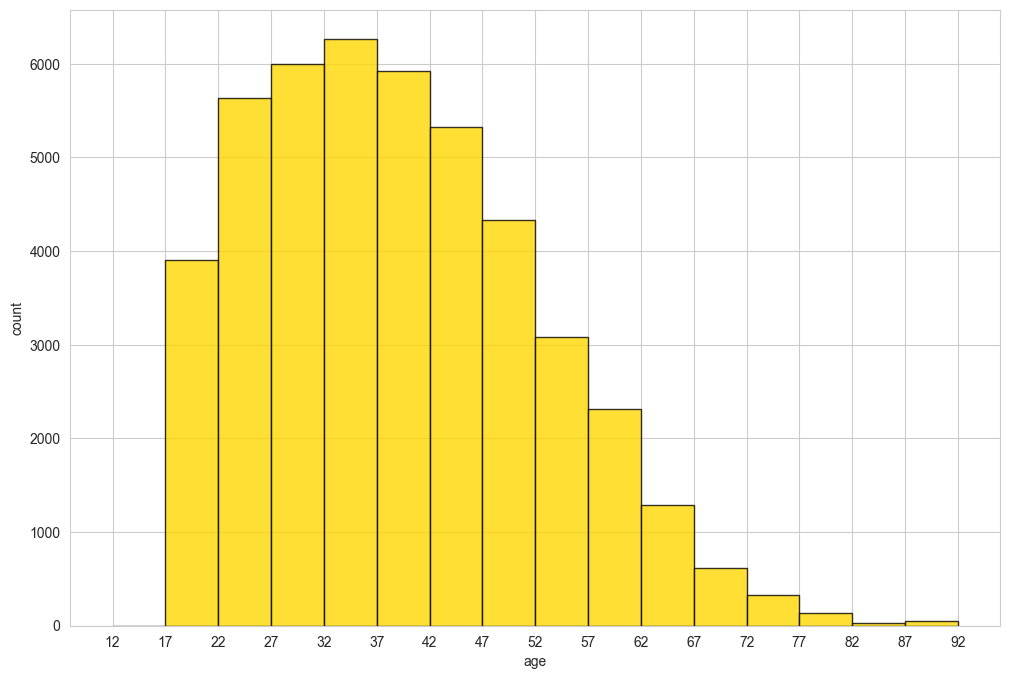

In [38]:
show_histogram(df, "age")

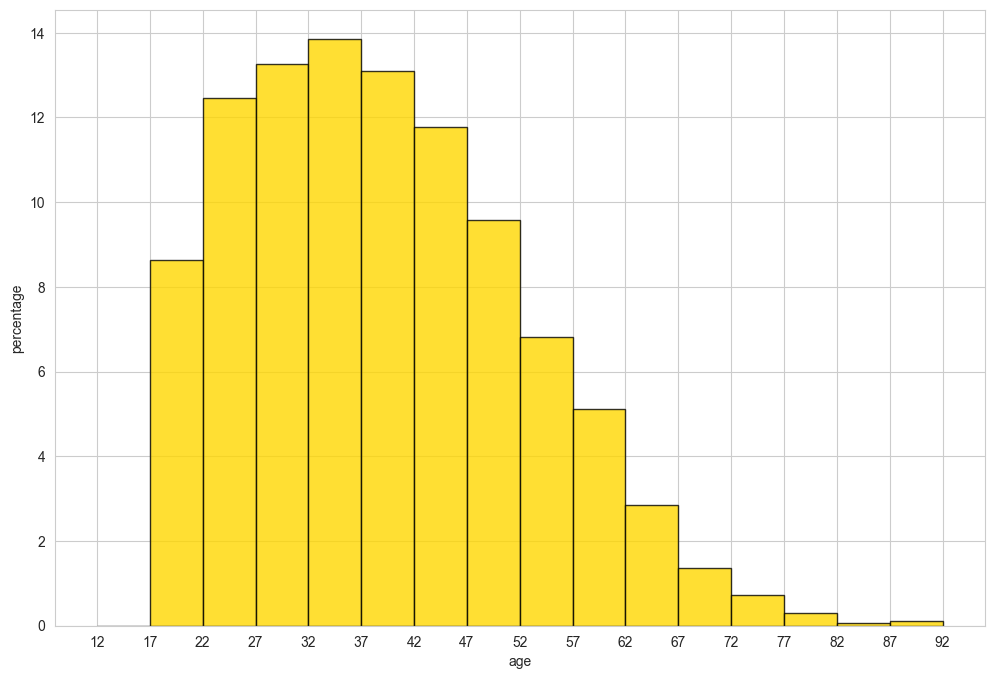

In [39]:
show_histogram(df, "age", percentage=True)

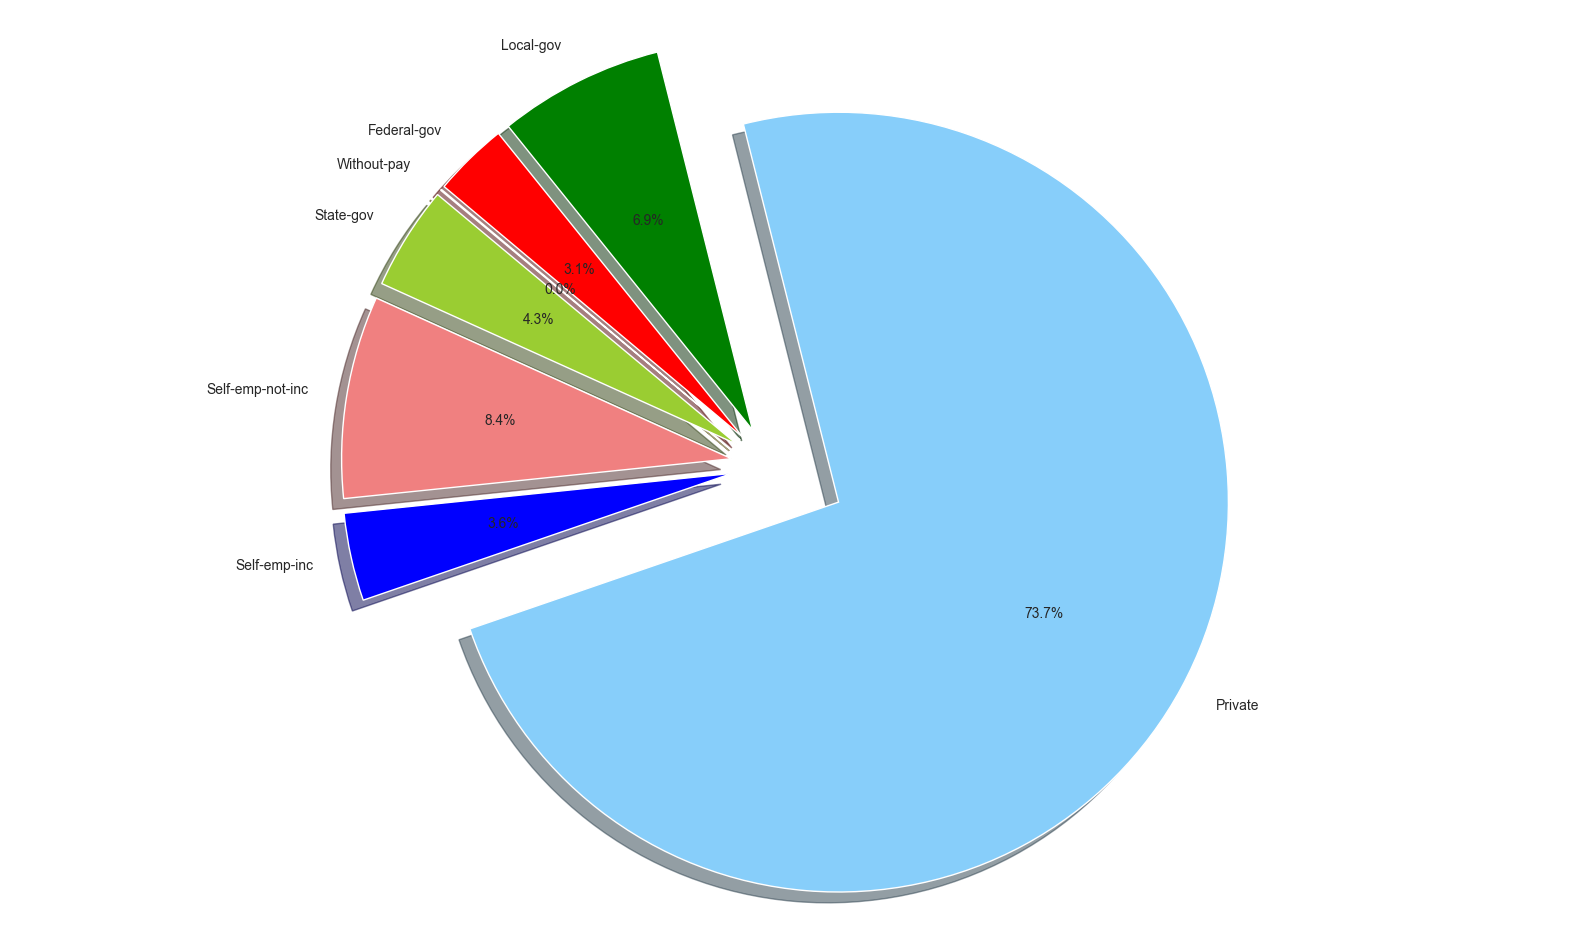

In [40]:
show_pie_chart(df, "workclass")

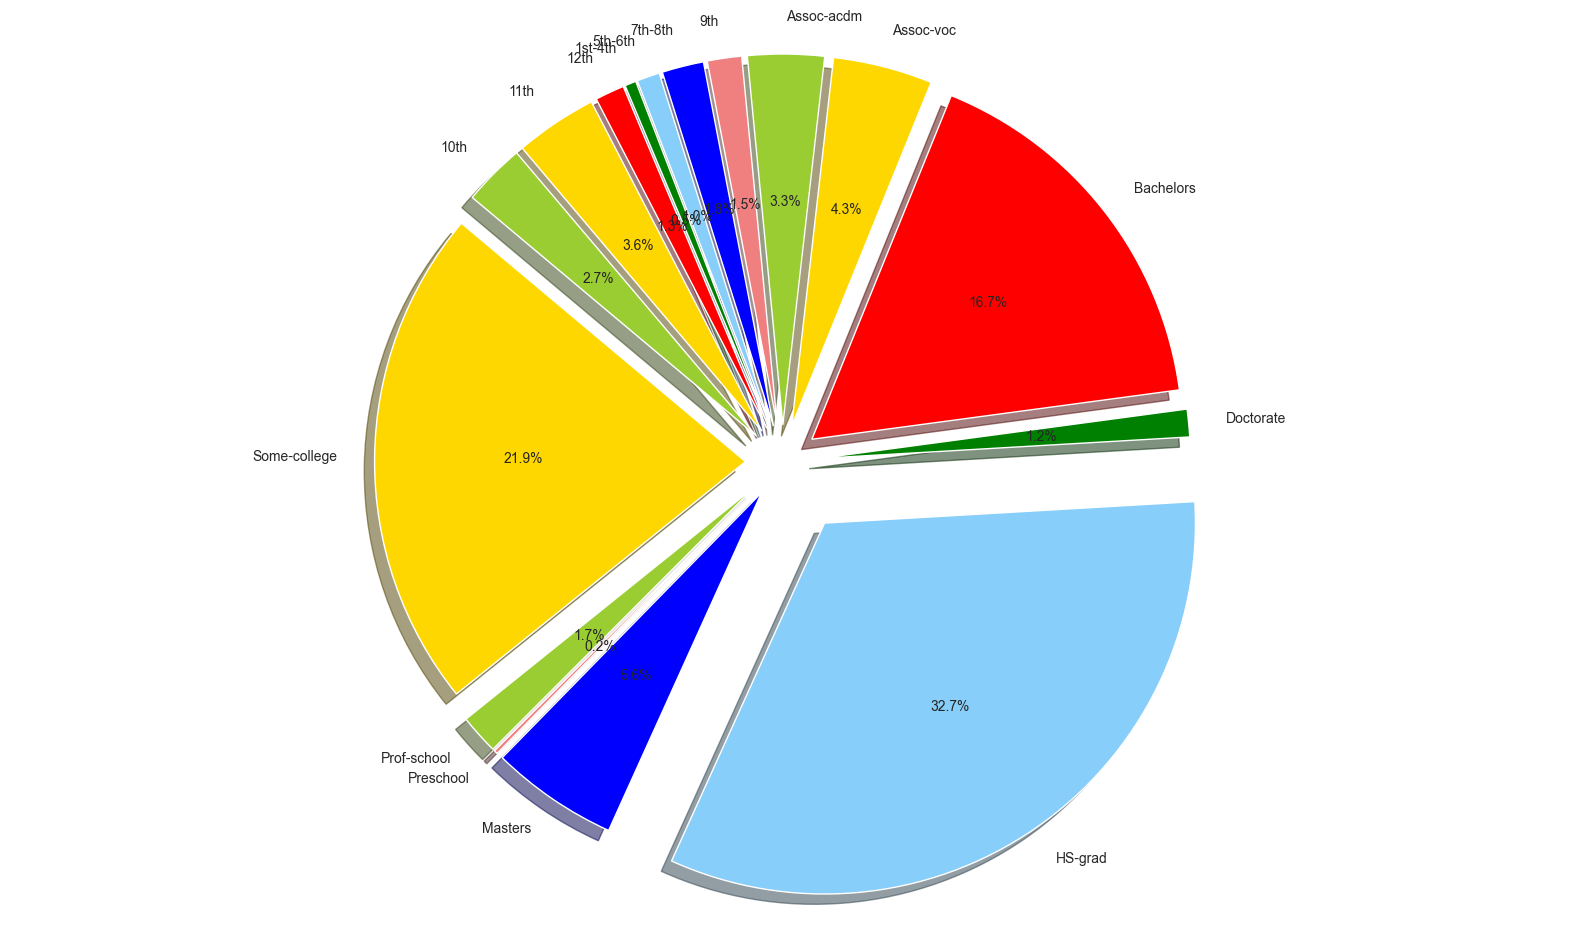

In [41]:
show_pie_chart(df, "education")

In [42]:
print_or_get_column_distinct_values(df, "education_num")

+-------------+-----+
|education_num|Count|
+-------------+-----+
|16.0         |544  |
|15.0         |785  |
|14.0         |2514 |
|13.0         |7570 |
|12.0         |1507 |
|11.0         |1959 |
|10.0         |9899 |
|9.0          |14783|
|8.0          |577  |
|7.0          |1619 |
|6.0          |1223 |
|5.0          |676  |
|4.0          |823  |
|3.0          |449  |
|2.0          |222  |
|1.0          |72   |
+-------------+-----+



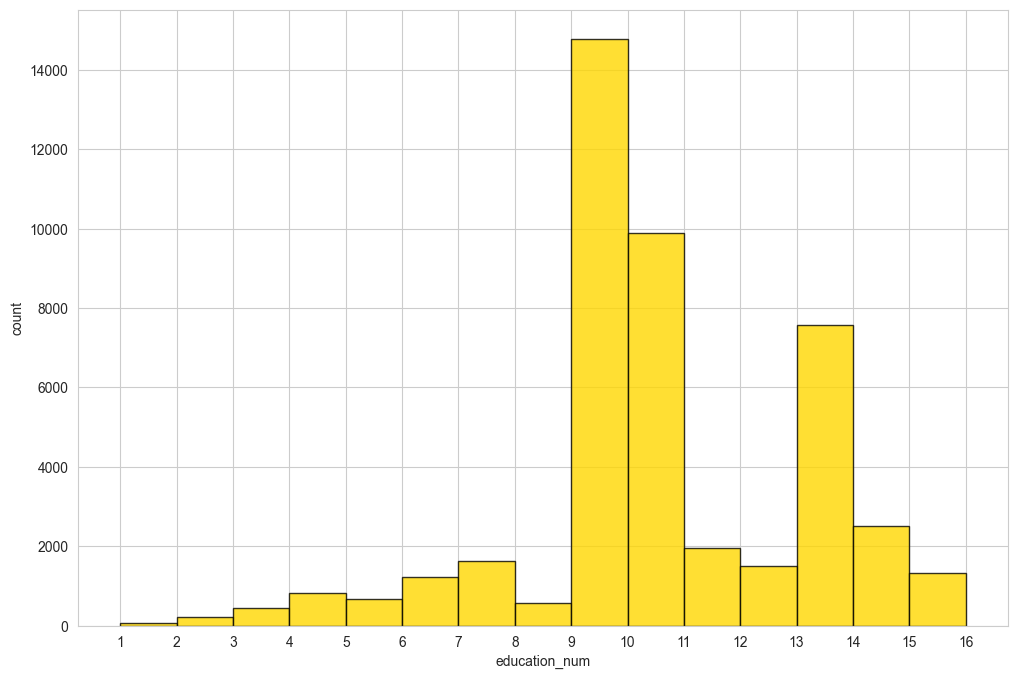

In [43]:
show_histogram(df, "education_num", bins=np.arange(1, 17, 1))

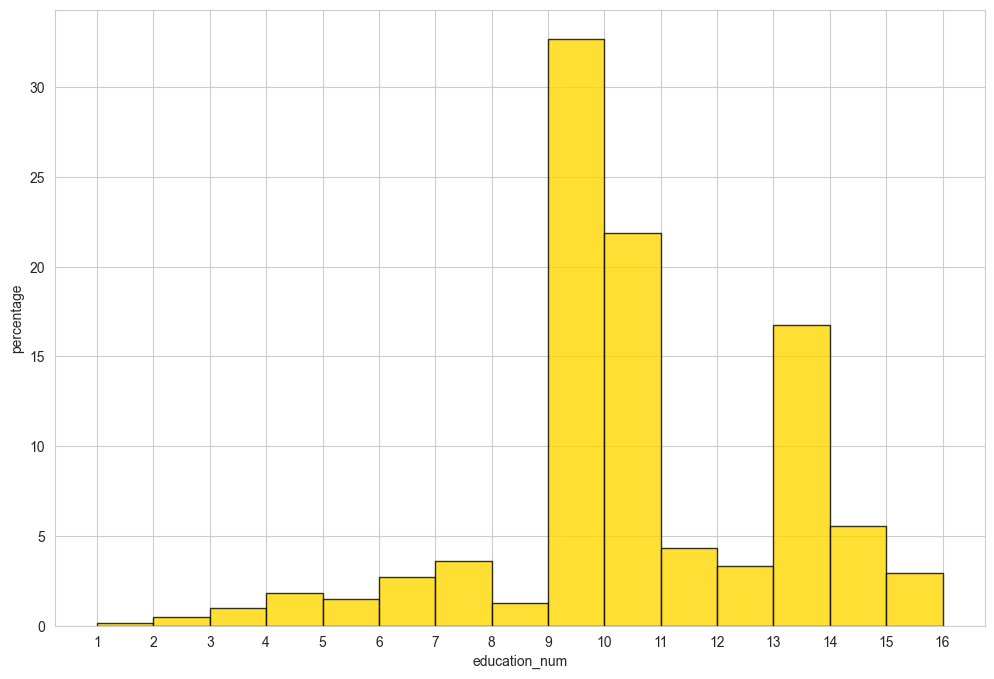

In [44]:
show_histogram(df, "education_num", bins=np.arange(1, 17, 1), percentage=True)

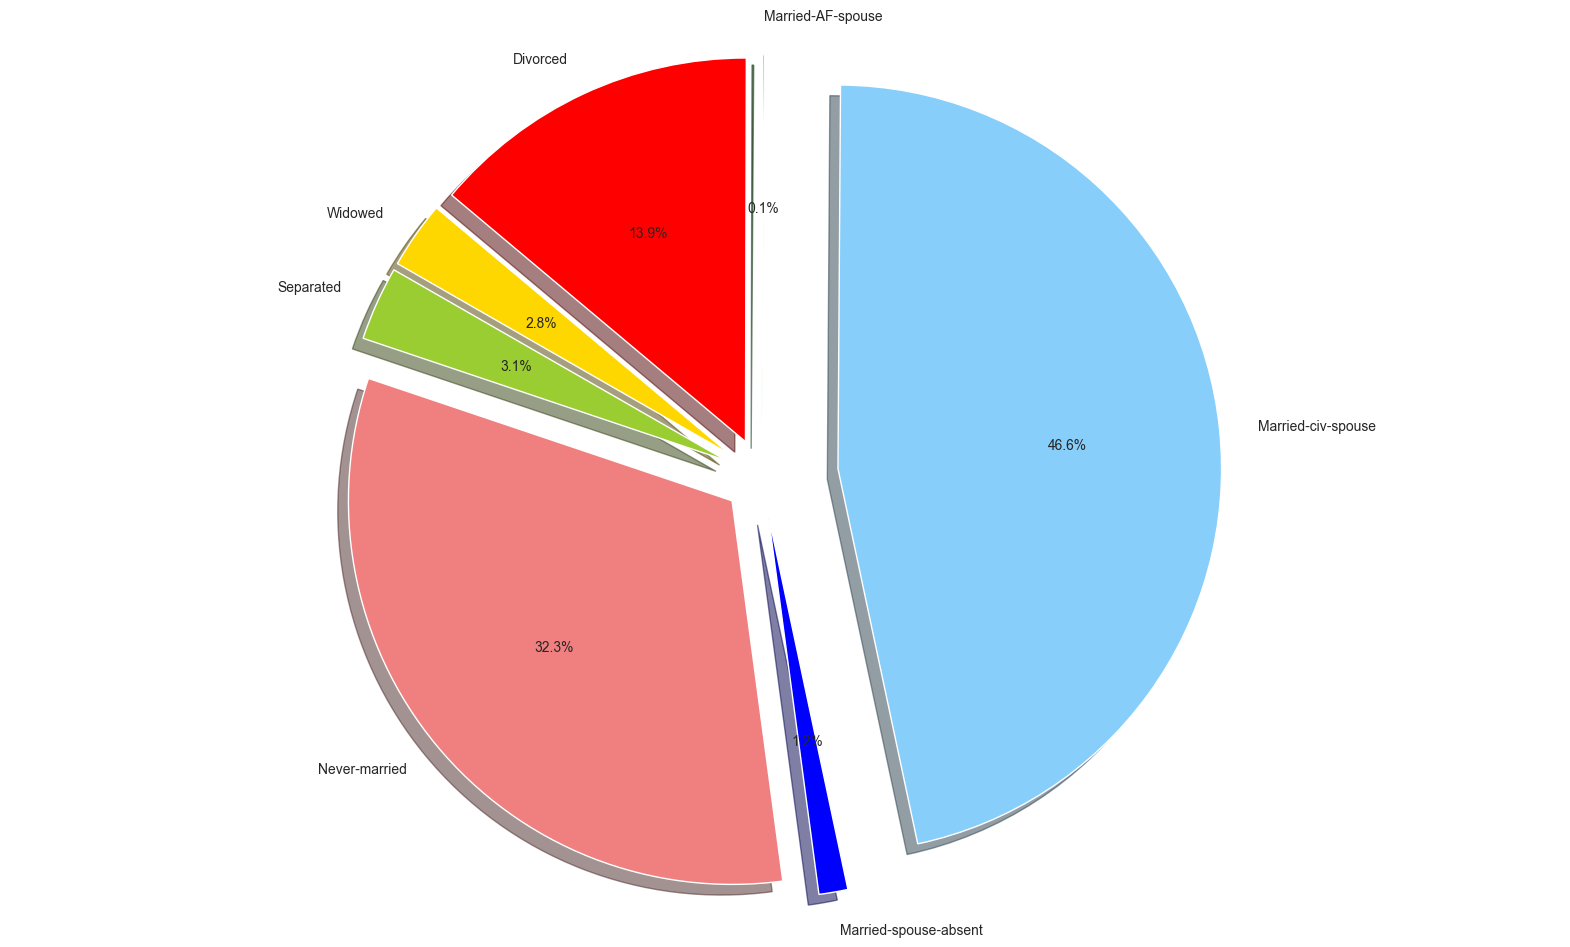

In [45]:
show_pie_chart(df, "marital_status")

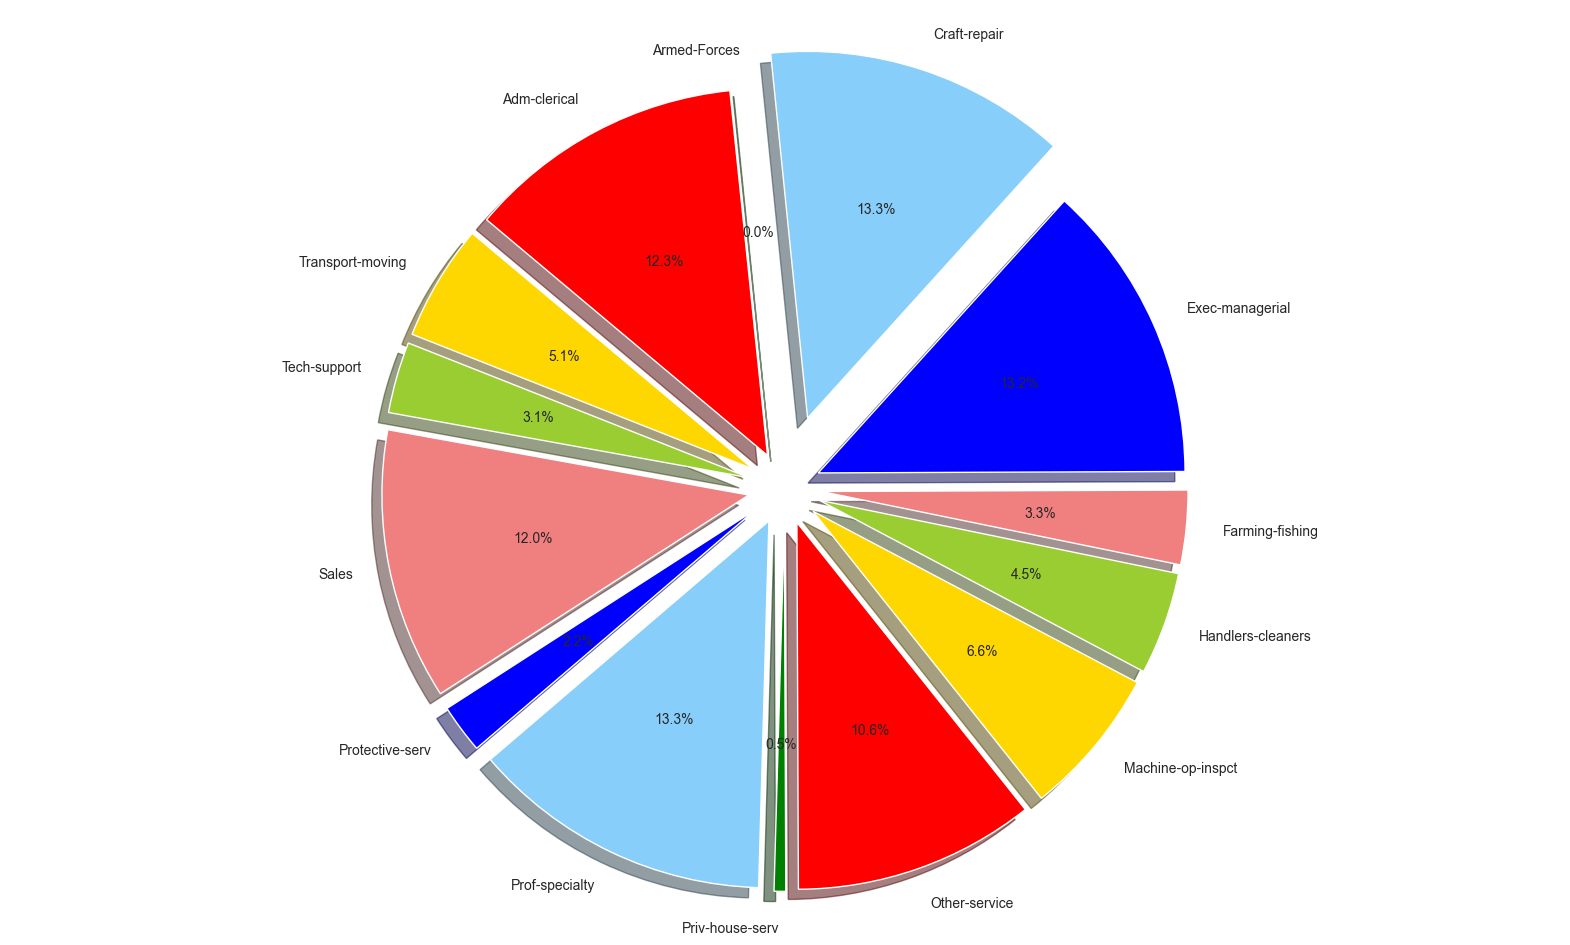

In [46]:
show_pie_chart(df, "occupation")

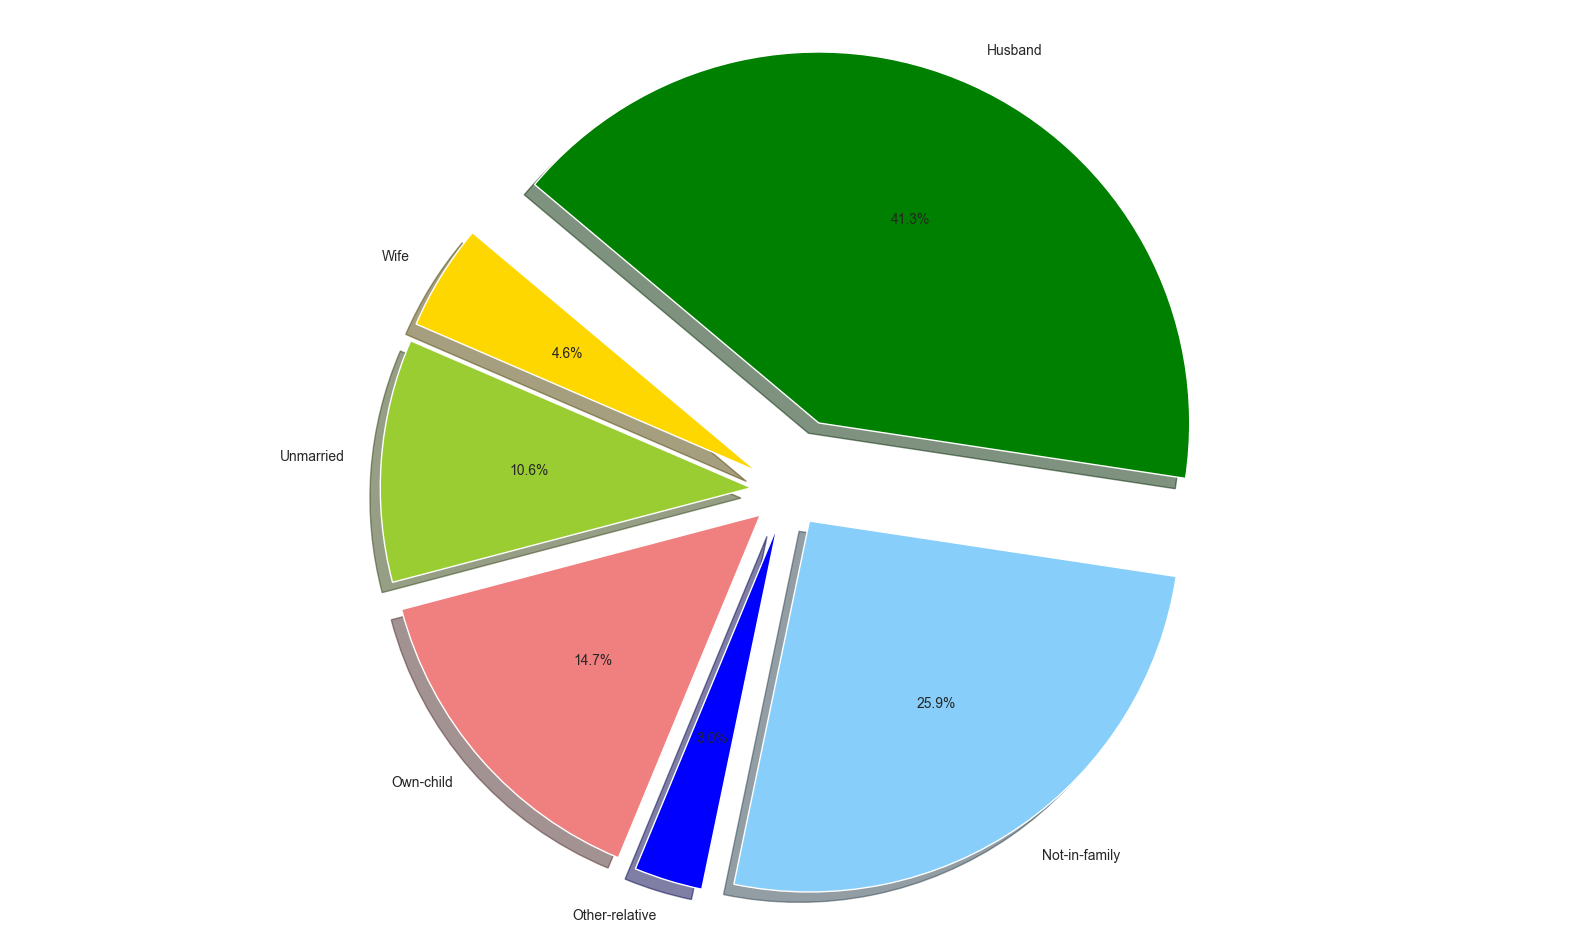

In [47]:
show_pie_chart(df, "relationship")

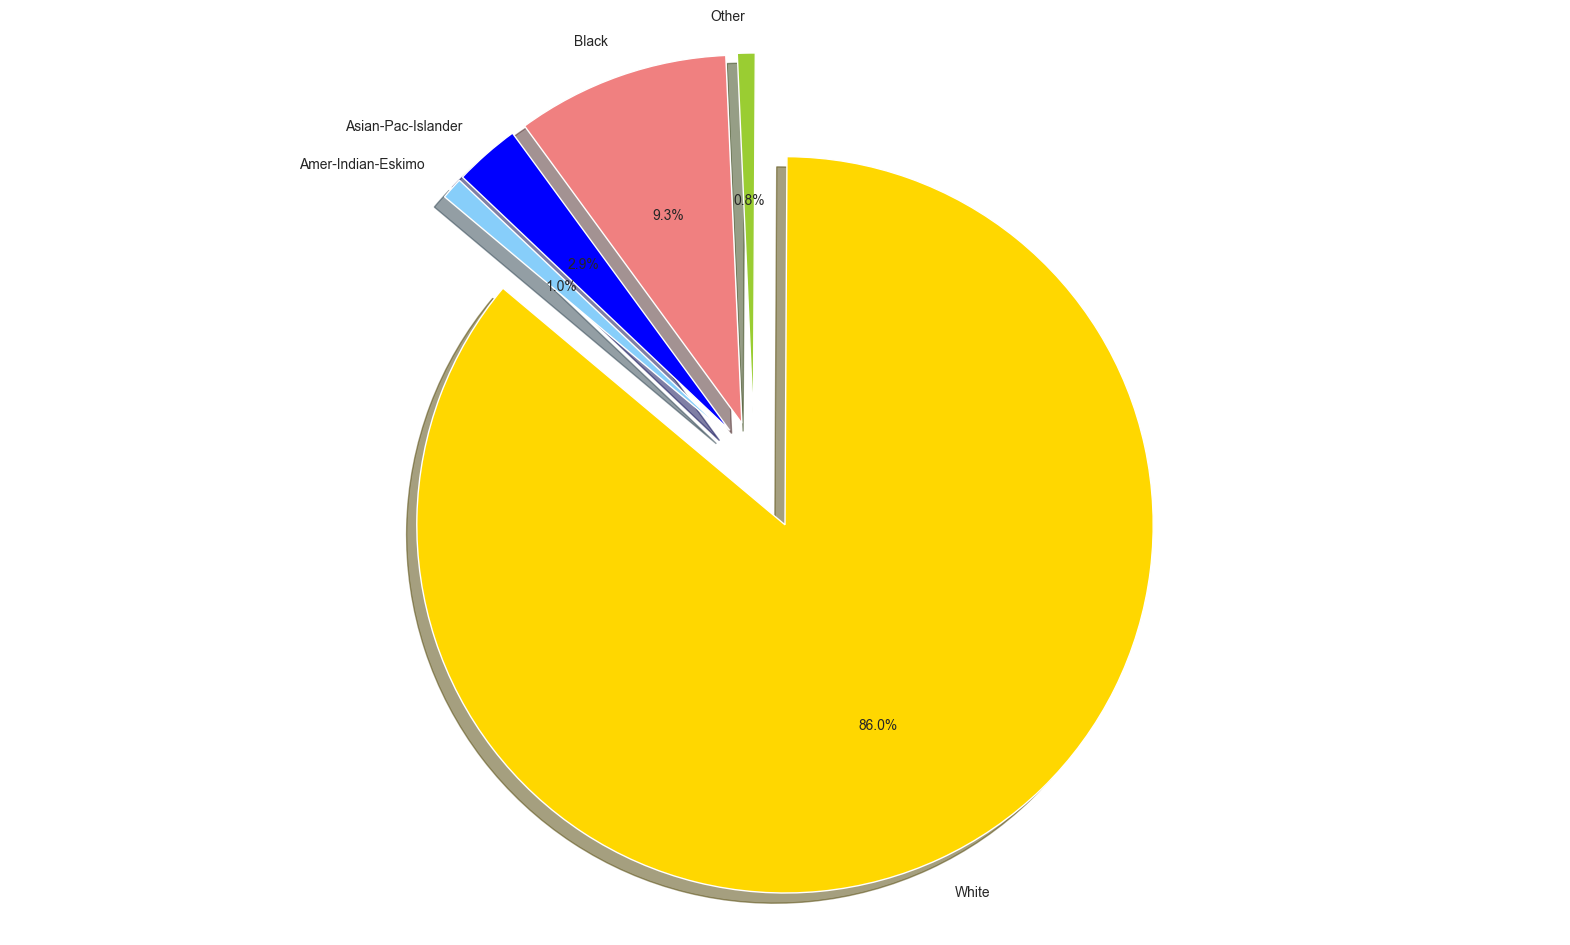

In [48]:
show_pie_chart(df, "race")

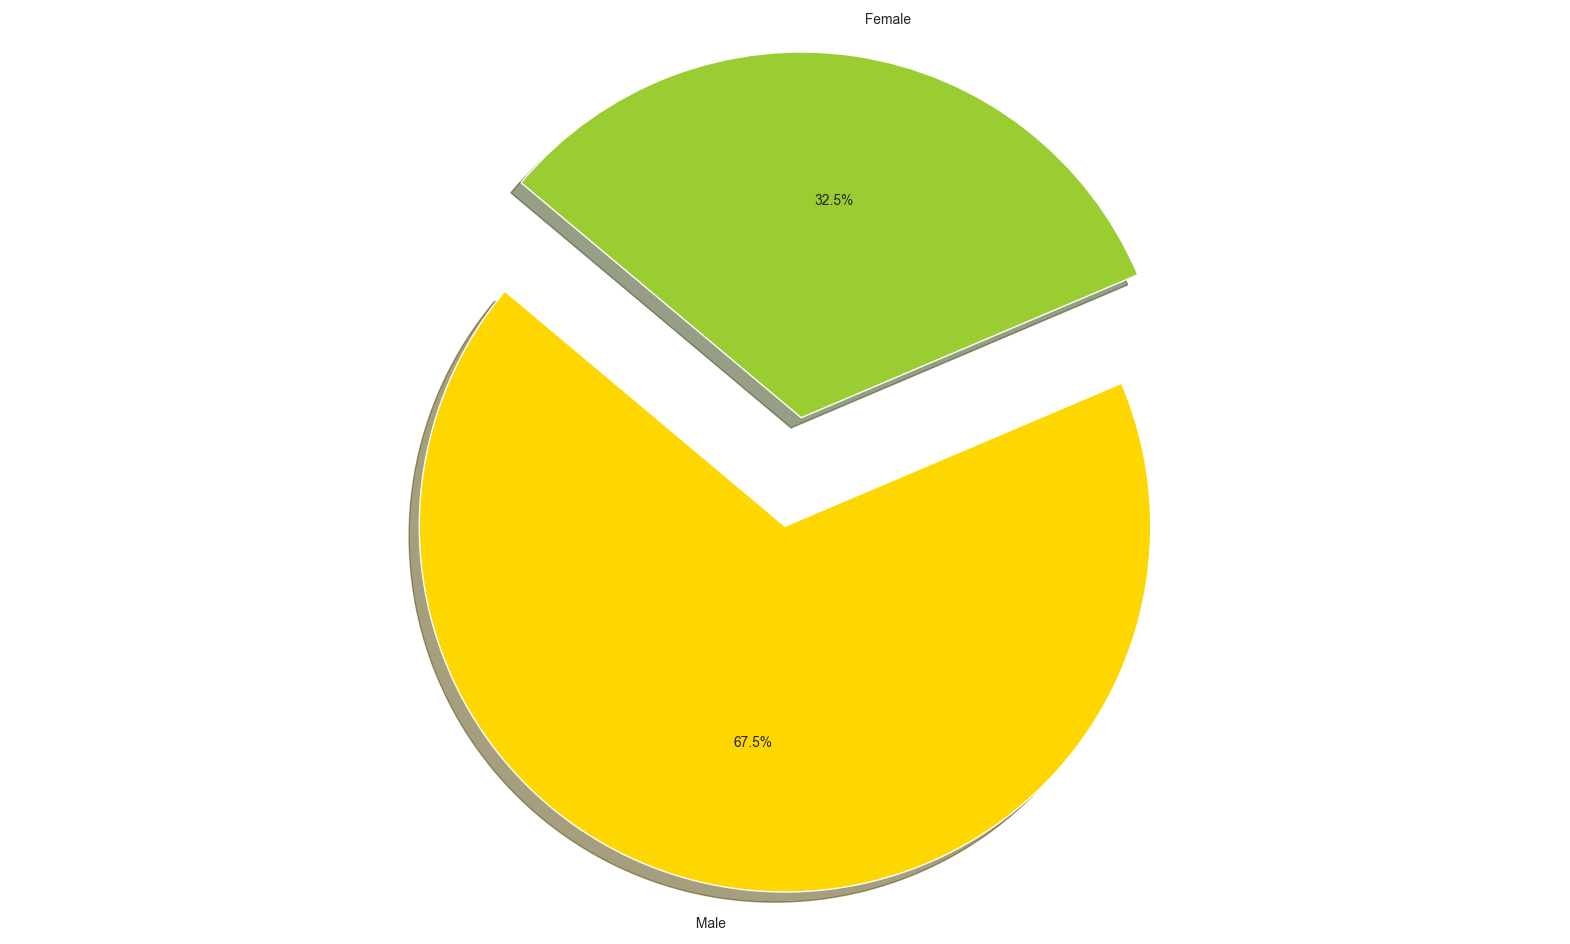

In [49]:
show_pie_chart(df, "sex")

In [50]:
print_or_get_column_distinct_values(df, "capital_gain")

+------------+-----+
|capital_gain|Count|
+------------+-----+
|99999.0     |229  |
|41310.0     |3    |
|34095.0     |4    |
|27828.0     |56   |
|25236.0     |14   |
|25124.0     |4    |
|22040.0     |1    |
|20051.0     |44   |
|18481.0     |2    |
|15831.0     |8    |
|15024.0     |498  |
|15020.0     |10   |
|14344.0     |34   |
|14084.0     |47   |
|13550.0     |40   |
|11678.0     |4    |
|10605.0     |16   |
|10566.0     |8    |
|10520.0     |64   |
|9562.0      |5    |
|9386.0      |23   |
|8614.0      |78   |
|7978.0      |2    |
|7896.0      |3    |
|7688.0      |391  |
|7443.0      |7    |
|7430.0      |14   |
|7298.0      |351  |
|7262.0      |1    |
|6849.0      |41   |
|6767.0      |4    |
|6723.0      |4    |
|6514.0      |9    |
|6497.0      |15   |
|6418.0      |14   |
|6360.0      |3    |
|6097.0      |2    |
|5721.0      |7    |
|5556.0      |5    |
|5455.0      |18   |
|5178.0      |137  |
|5060.0      |2    |
|5013.0      |116  |
|4934.0      |10   |
|4931.0      

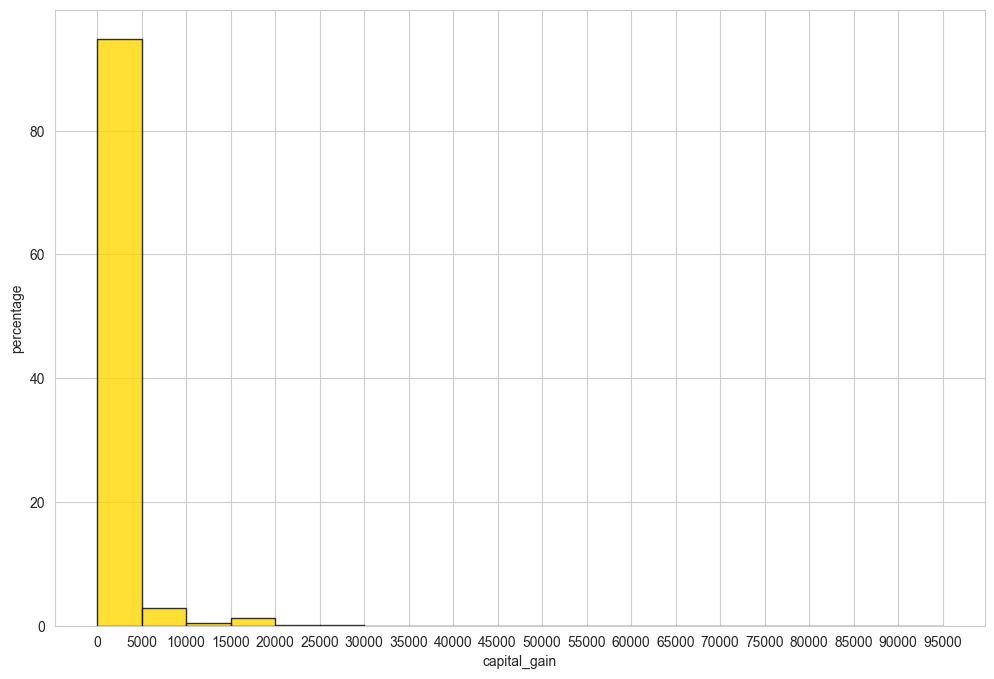

In [51]:
show_histogram(
        df,
        "capital_gain",
        bins=np.arange(0, 100_000, 5000),
        percentage=True,
)

In [52]:
print_or_get_column_distinct_values(df, "capital_loss")

+------------+-----+
|capital_loss|Count|
+------------+-----+
|4356.0      |1    |
|3900.0      |2    |
|3770.0      |4    |
|3683.0      |2    |
|3175.0      |2    |
|3004.0      |4    |
|2824.0      |12   |
|2754.0      |2    |
|2603.0      |5    |
|2559.0      |17   |
|2547.0      |5    |
|2472.0      |4    |
|2467.0      |2    |
|2457.0      |2    |
|2444.0      |20   |
|2415.0      |68   |
|2392.0      |10   |
|2377.0      |21   |
|2352.0      |2    |
|2339.0      |24   |
|2282.0      |2    |
|2267.0      |3    |
|2258.0      |39   |
|2246.0      |8    |
|2238.0      |4    |
|2231.0      |7    |
|2206.0      |5    |
|2205.0      |16   |
|2201.0      |1    |
|2179.0      |19   |
|2174.0      |8    |
|2163.0      |1    |
|2149.0      |3    |
|2129.0      |5    |
|2080.0      |1    |
|2057.0      |15   |
|2051.0      |29   |
|2042.0      |12   |
|2002.0      |31   |
|2001.0      |32   |
|1980.0      |36   |
|1977.0      |246  |
|1974.0      |27   |
|1944.0      |3    |
|1911.0      

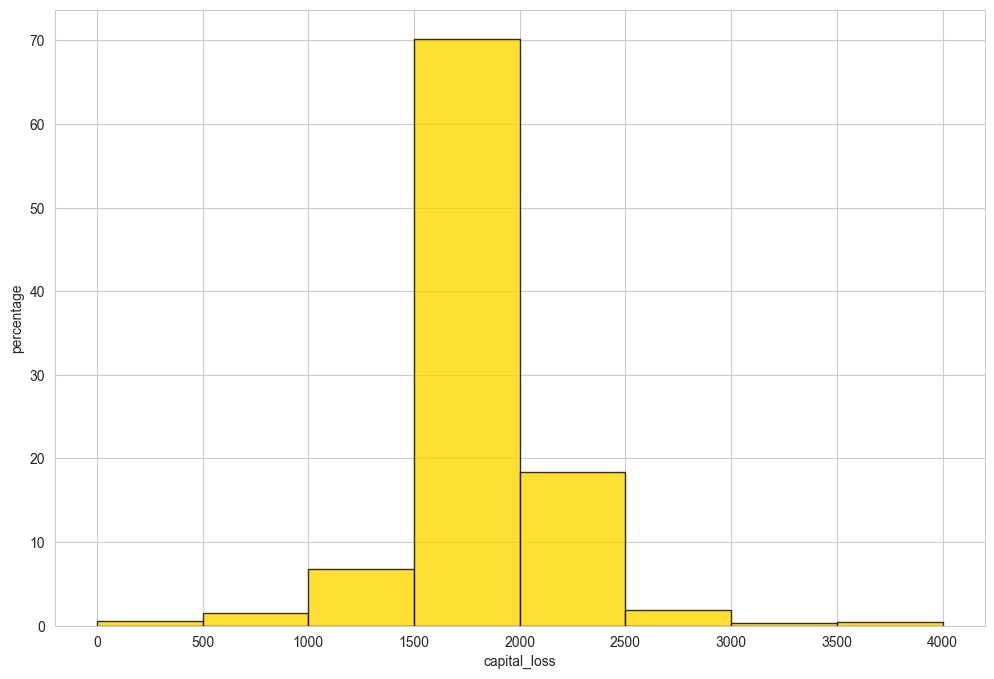

In [53]:
show_histogram(
        df.select("capital_loss").where(F.col("capital_loss") > 0),
        "capital_loss",
        bins=np.arange(0, 4500, 500),
        percentage=True,
)

In [54]:
print_or_get_column_distinct_values(df, "hours_per_week")

+--------------+-----+
|hours_per_week|Count|
+--------------+-----+
|99.0          |123  |
|98.0          |14   |
|97.0          |2    |
|96.0          |9    |
|95.0          |2    |
|94.0          |1    |
|92.0          |3    |
|91.0          |3    |
|90.0          |41   |
|89.0          |3    |
|88.0          |4    |
|87.0          |1    |
|86.0          |4    |
|85.0          |17   |
|84.0          |65   |
|82.0          |1    |
|81.0          |3    |
|80.0          |189  |
|79.0          |1    |
|78.0          |13   |
|77.0          |9    |
|76.0          |4    |
|75.0          |100  |
|74.0          |3    |
|73.0          |3    |
|72.0          |97   |
|70.0          |418  |
|69.0          |1    |
|68.0          |16   |
|67.0          |6    |
|66.0          |22   |
|65.0          |349  |
|64.0          |21   |
|63.0          |14   |
|62.0          |23   |
|61.0          |4    |
|60.0          |2085 |
|59.0          |6    |
|58.0          |37   |
|57.0          |19   |
|56.0      

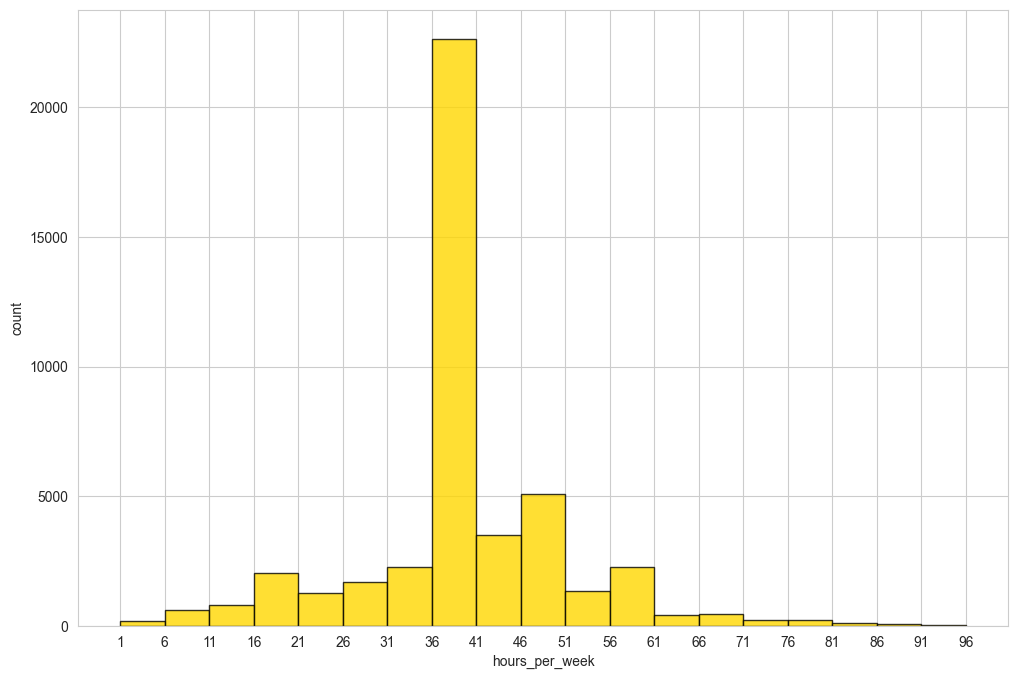

In [55]:
show_histogram(df, "hours_per_week", np.arange(1, 100, 5))

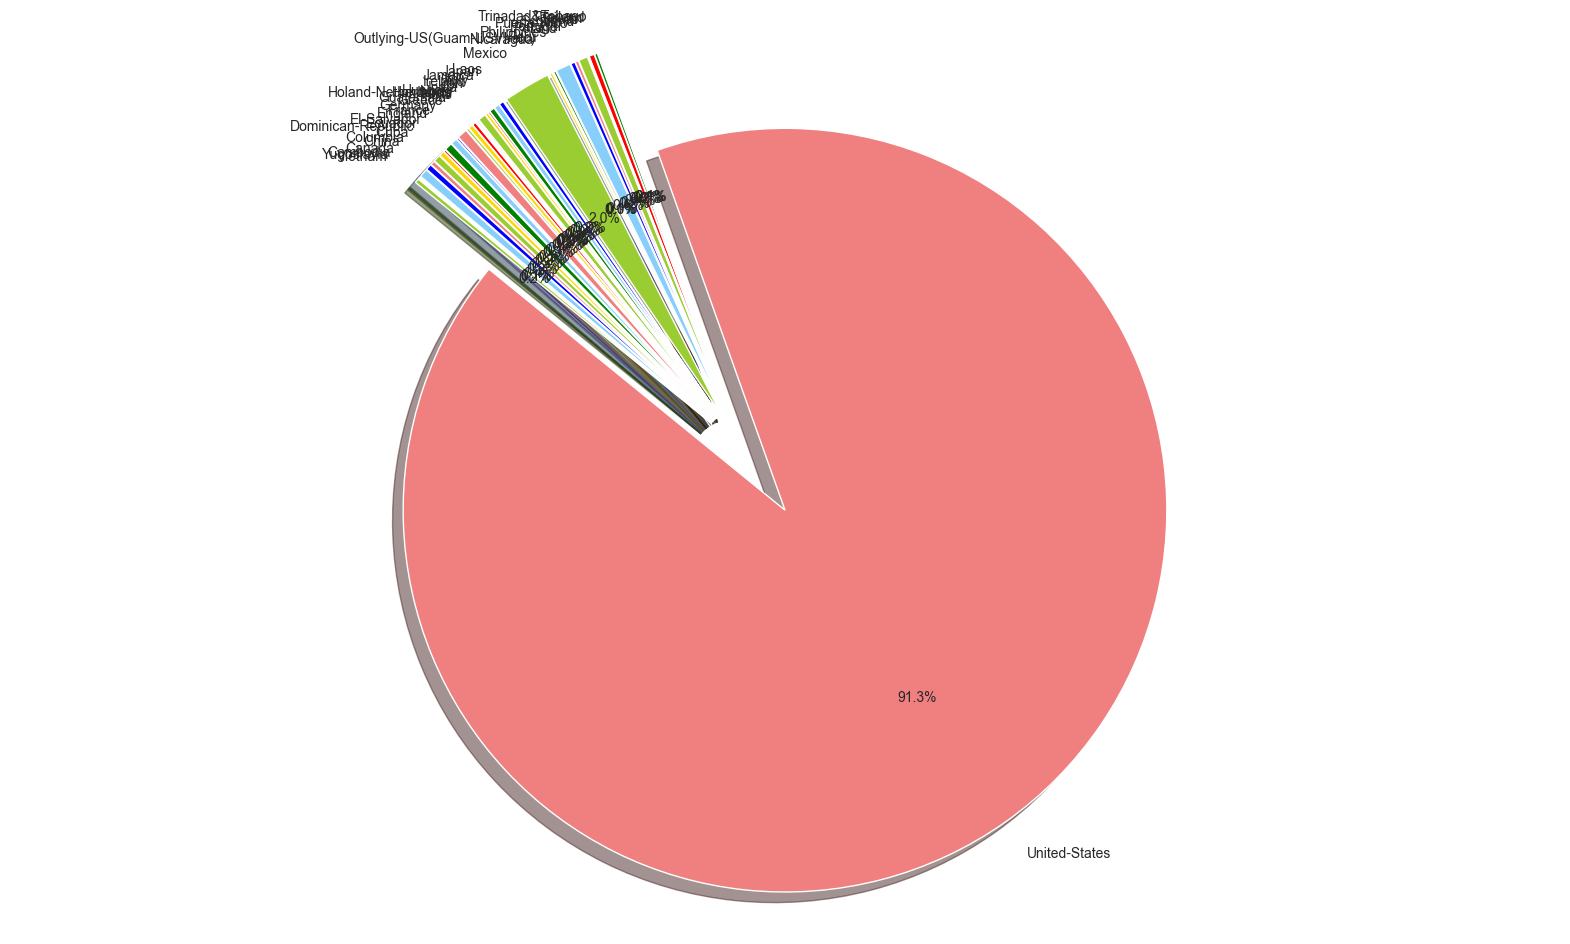

In [56]:
show_pie_chart(df, "native_country")

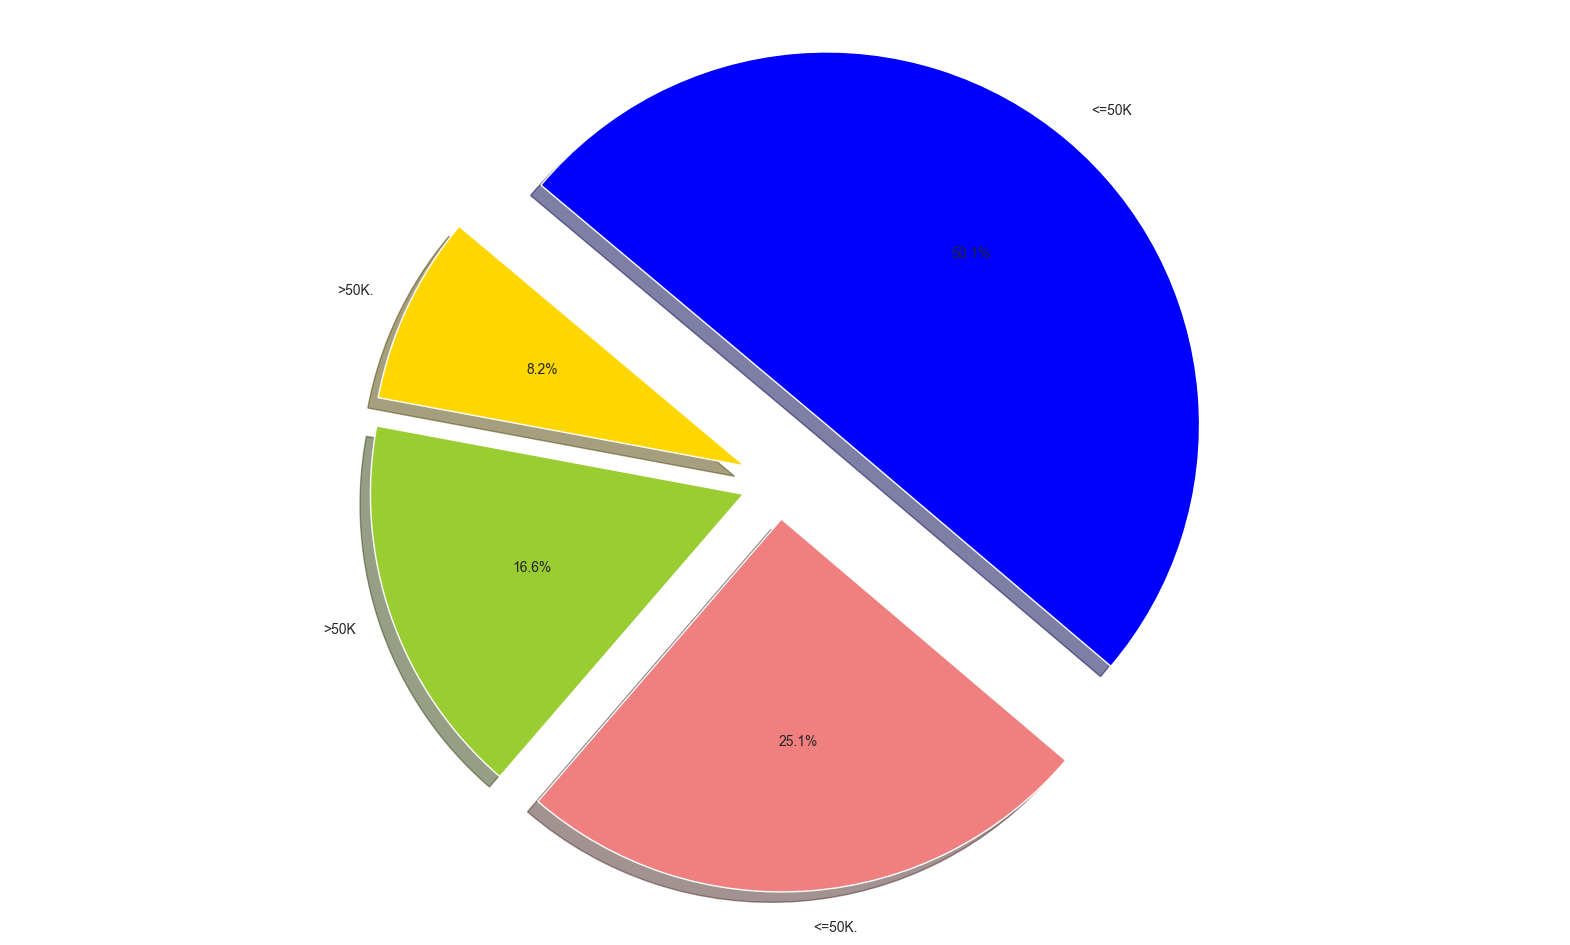

In [57]:
show_pie_chart(df, "income")

---
# 3. Feature Engineering

In [58]:
def remove_columns_with_one_distinct_value(
        dataframe: pyspark.sql.DataFrame,
        column_names: List[str],
) -> Tuple[pyspark.sql.DataFrame, List[str]]:
    columns_to_be_removed = []
    for column_name in column_names:
        distinct_value_count = column_distinct_values_count(dataframe, column_name)
        if distinct_value_count < 2:
            print(f"{column_name} has only one distinct value")
            columns_to_be_removed.append(column_name)

    for column_name in columns_to_be_removed:
        column_names.remove(column_name)
        dataframe = dataframe.drop(column_name)

    return dataframe, columns_to_be_removed

In [59]:
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- workclass: string (nullable = true)
 |-- fnlwgt: double (nullable = true)
 |-- education: string (nullable = true)
 |-- education_num: double (nullable = true)
 |-- marital_status: string (nullable = true)
 |-- occupation: string (nullable = true)
 |-- relationship: string (nullable = true)
 |-- race: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- capital_gain: double (nullable = true)
 |-- capital_loss: double (nullable = true)
 |-- hours_per_week: double (nullable = true)
 |-- native_country: string (nullable = true)
 |-- income: string (nullable = true)
 |-- is_train: integer (nullable = false)



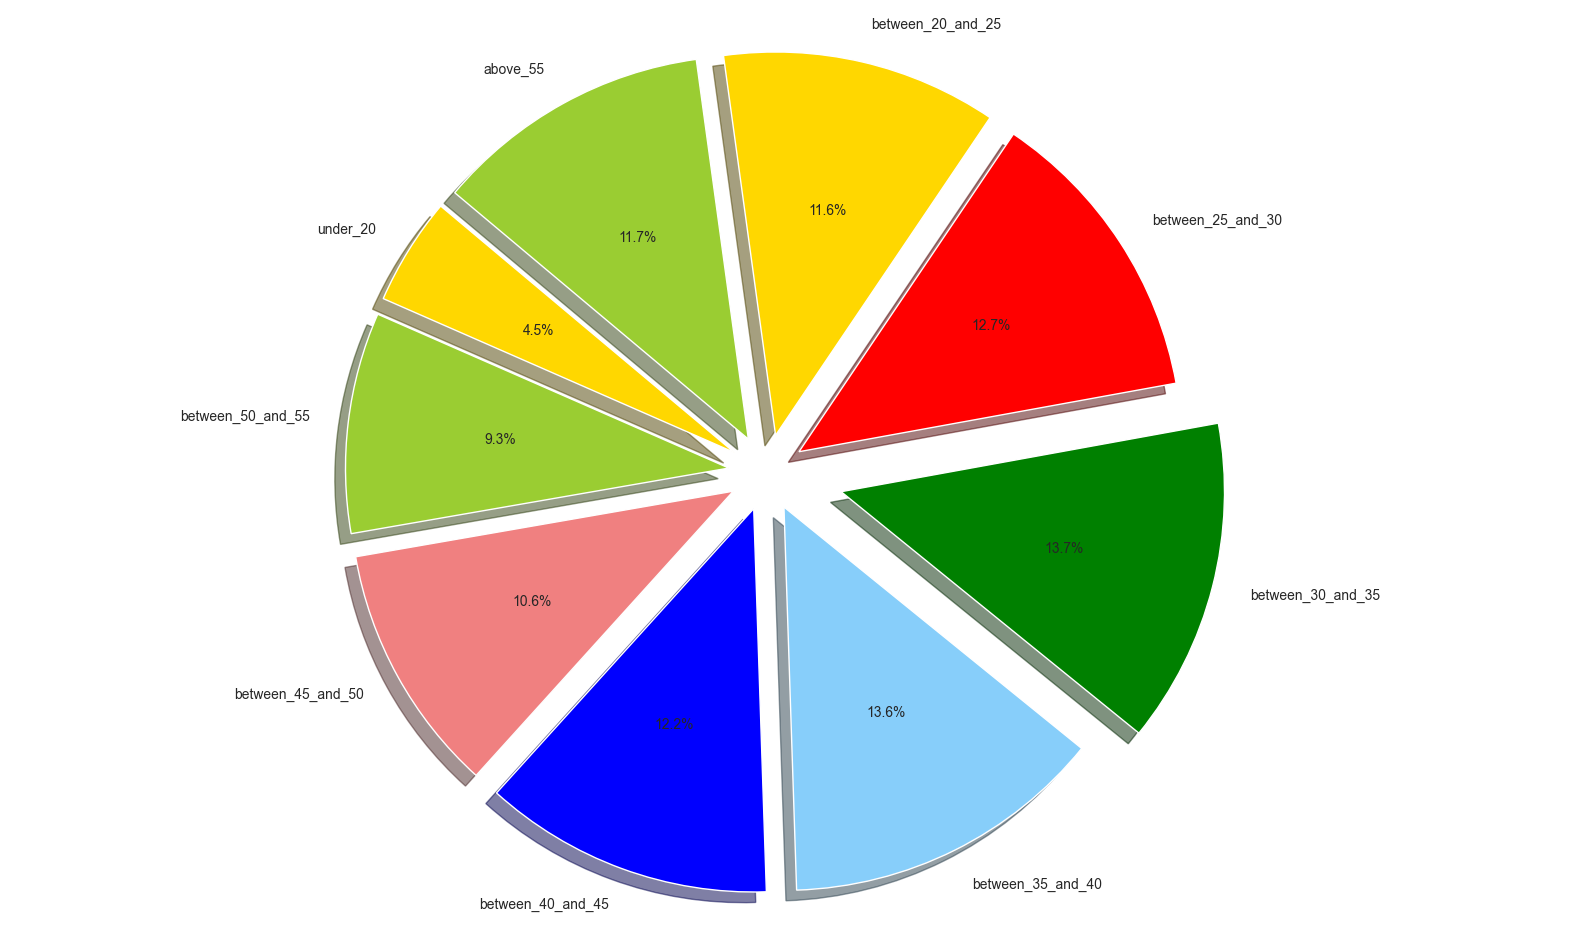

In [60]:
# categorize `age` column
def categorize_age_column(row_value: int) -> str:
    if row_value < 20:
        return "under_20"
    elif 20 <= row_value < 25:
        return "between_20_and_25"
    elif 25 <= row_value < 30:
        return "between_25_and_30"
    elif 30 <= row_value < 35:
        return "between_30_and_35"
    elif 35 <= row_value < 40:
        return "between_35_and_40"
    elif 40 <= row_value < 45:
        return "between_40_and_45"
    elif 45 <= row_value < 50:
        return "between_45_and_50"
    elif 50 <= row_value <= 55:
        return "between_50_and_55"
    else:
        return "above_55"


df = df.withColumn(
        "age_cat", F.udf(lambda row_value: categorize_age_column(row_value))(F.col("age"))
)
show_pie_chart(df, "age_cat")

# drop the `age` column, it is not required anymore
df = df.drop("age")

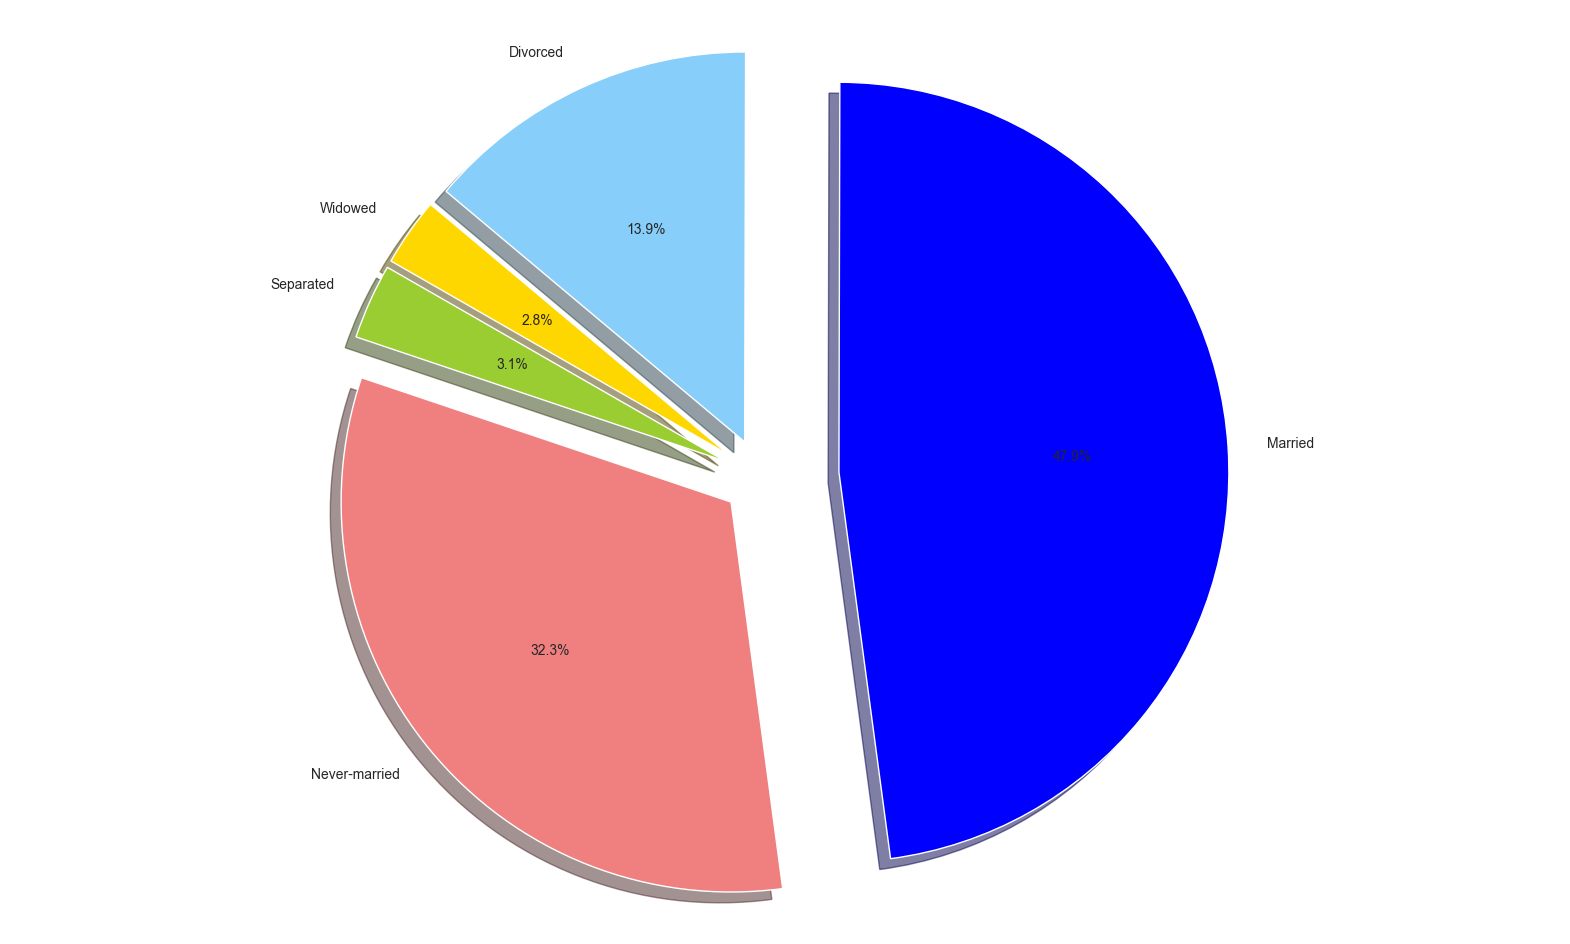

In [61]:
# combine three similar statuses in the `marital_status` to one class
df = df.replace(
        ["Married-civ-spouse", "Married-AF-spouse", "Married-spouse-absent"], "Married"
)
show_pie_chart(df, "marital_status")

In [62]:
# the `fnlwgt` column is not a predictive feature, so it can be dropped
df = df.drop("fnlwgt")
df.printSchema()

root
 |-- workclass: string (nullable = true)
 |-- education: string (nullable = true)
 |-- education_num: double (nullable = true)
 |-- marital_status: string (nullable = true)
 |-- occupation: string (nullable = true)
 |-- relationship: string (nullable = true)
 |-- race: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- capital_gain: double (nullable = true)
 |-- capital_loss: double (nullable = true)
 |-- hours_per_week: double (nullable = true)
 |-- native_country: string (nullable = true)
 |-- income: string (nullable = true)
 |-- is_train: integer (nullable = false)
 |-- age_cat: string (nullable = true)



In [63]:
# the `capital_gain` and `capital_loss` columns can be converted into a new column named `capital` which is
# calculated by subtracting the `capital_loss` column from the `capital_gain` column

df = df.withColumn("capital", df["capital_gain"] - df["capital_loss"])

# the `capital_gain` and `capital_loss` columns can be dropped now
for col_name in ["capital_gain", "capital_loss"]:
    df = df.drop(col_name)

In [64]:
print_or_get_column_distinct_values(df, "capital")

+-------+-----+
|capital|Count|
+-------+-----+
|99999.0|229  |
|41310.0|3    |
|34095.0|4    |
|27828.0|56   |
|25236.0|14   |
|25124.0|4    |
|22040.0|1    |
|20051.0|44   |
|18481.0|2    |
|15831.0|8    |
|15024.0|498  |
|15020.0|10   |
|14344.0|34   |
|14084.0|47   |
|13550.0|40   |
|11678.0|4    |
|10605.0|16   |
|10566.0|8    |
|10520.0|64   |
|9562.0 |5    |
|9386.0 |23   |
|8614.0 |78   |
|7978.0 |2    |
|7896.0 |3    |
|7688.0 |391  |
|7443.0 |7    |
|7430.0 |14   |
|7298.0 |351  |
|7262.0 |1    |
|6849.0 |41   |
|6767.0 |4    |
|6723.0 |4    |
|6514.0 |9    |
|6497.0 |15   |
|6418.0 |14   |
|6360.0 |3    |
|6097.0 |2    |
|5721.0 |7    |
|5556.0 |5    |
|5455.0 |18   |
|5178.0 |137  |
|5060.0 |2    |
|5013.0 |116  |
|4934.0 |10   |
|4931.0 |4    |
|4865.0 |24   |
|4787.0 |34   |
|4687.0 |4    |
|4650.0 |62   |
|4508.0 |21   |
|4416.0 |23   |
|4386.0 |102  |
|4101.0 |28   |
|4064.0 |52   |
|3942.0 |16   |
|3908.0 |41   |
|3887.0 |8    |
|3818.0 |8    |
|3781.0 |14   |
|3674.0 

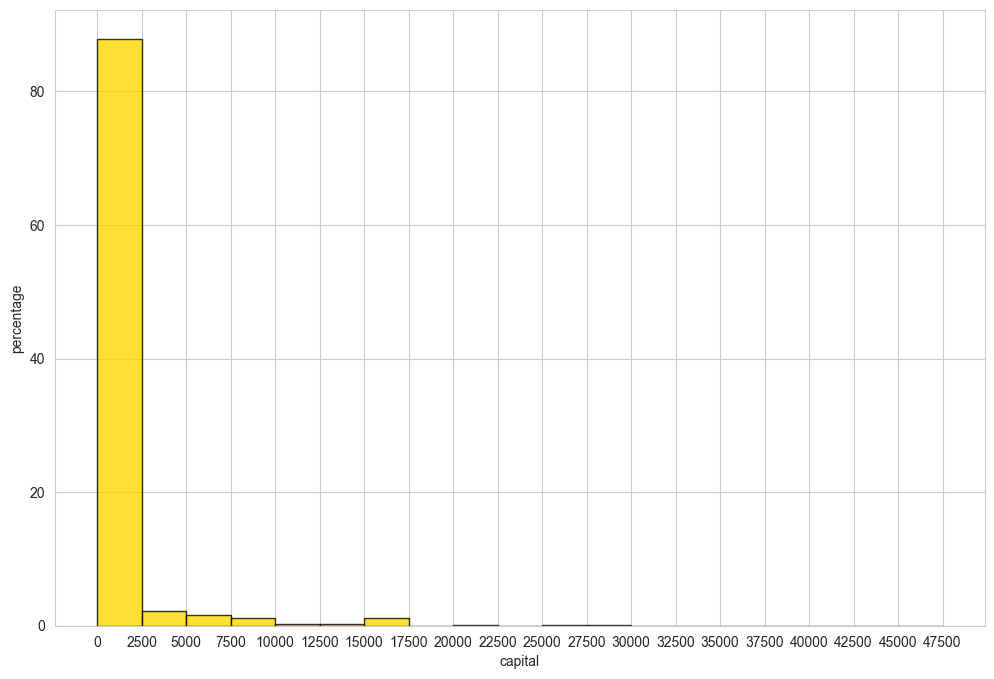

In [65]:
show_histogram(
        df,
        "capital",
        bins=np.arange(0, 50_000, 2500),
        percentage=True,
)

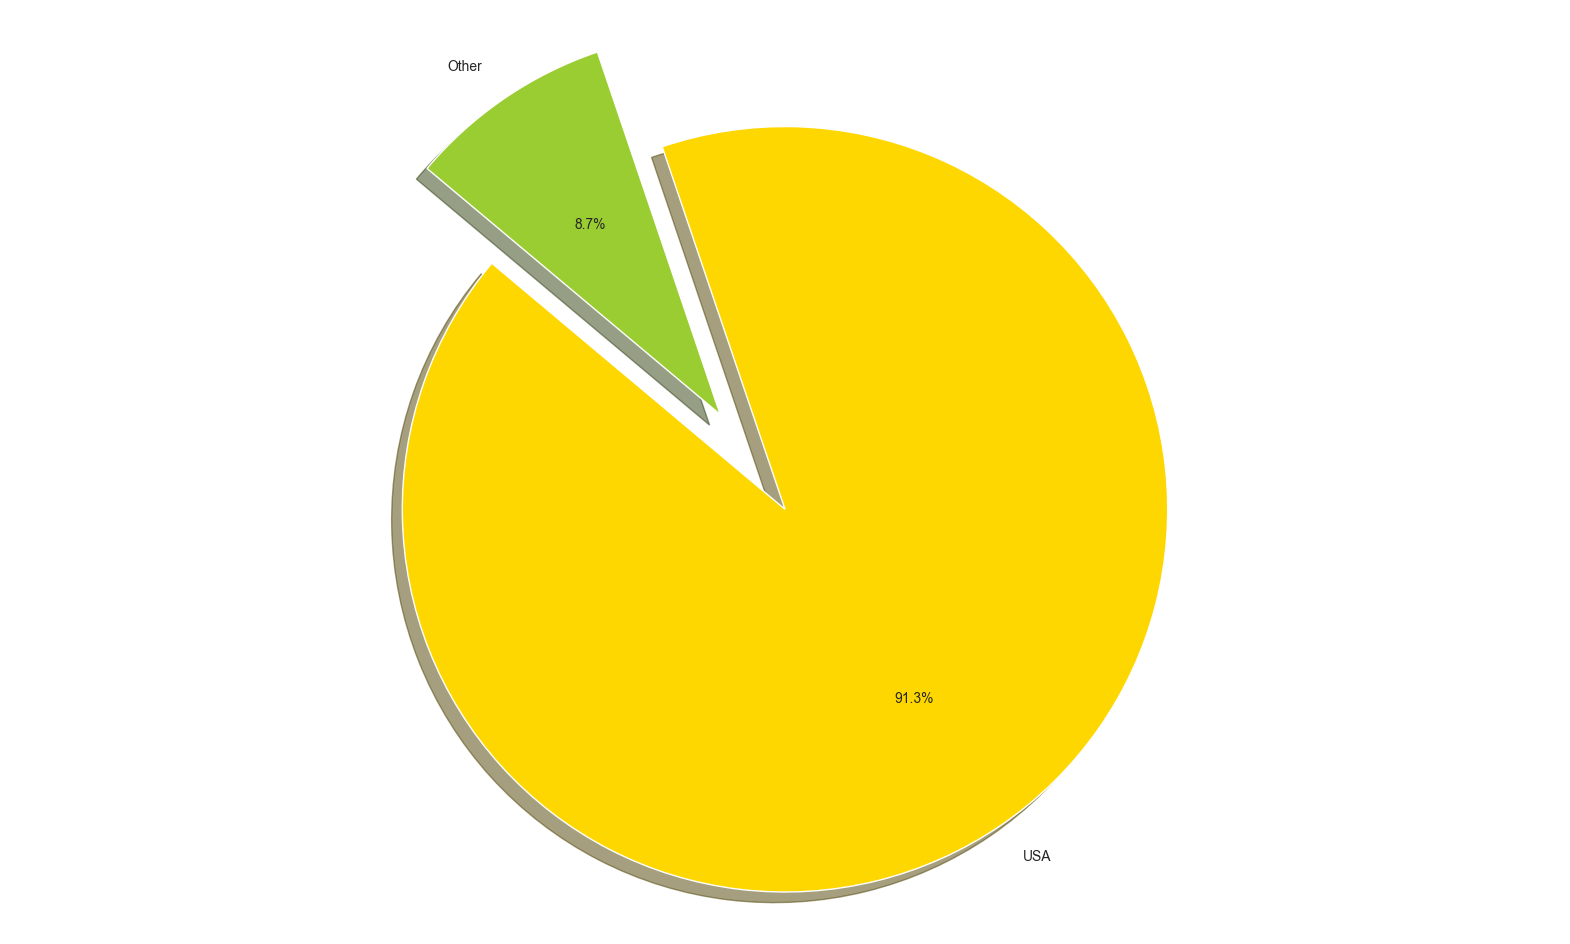

In [66]:
# There are not many number of instances for countries other than the USA. Other country names can be changed to `Other`
def convert_native_country_column(row_value: str) -> str:
    if row_value == "United-States":
        return "USA"
    else:
        return "Other"


df = df.withColumn("native_country", F.udf(lambda row: convert_native_country_column(row))(F.col("native_country")))
show_pie_chart(df, "native_country")

In [67]:
# the `education_num` column is the number for the `education` column, it can be dropped
df = df.drop("education_num")

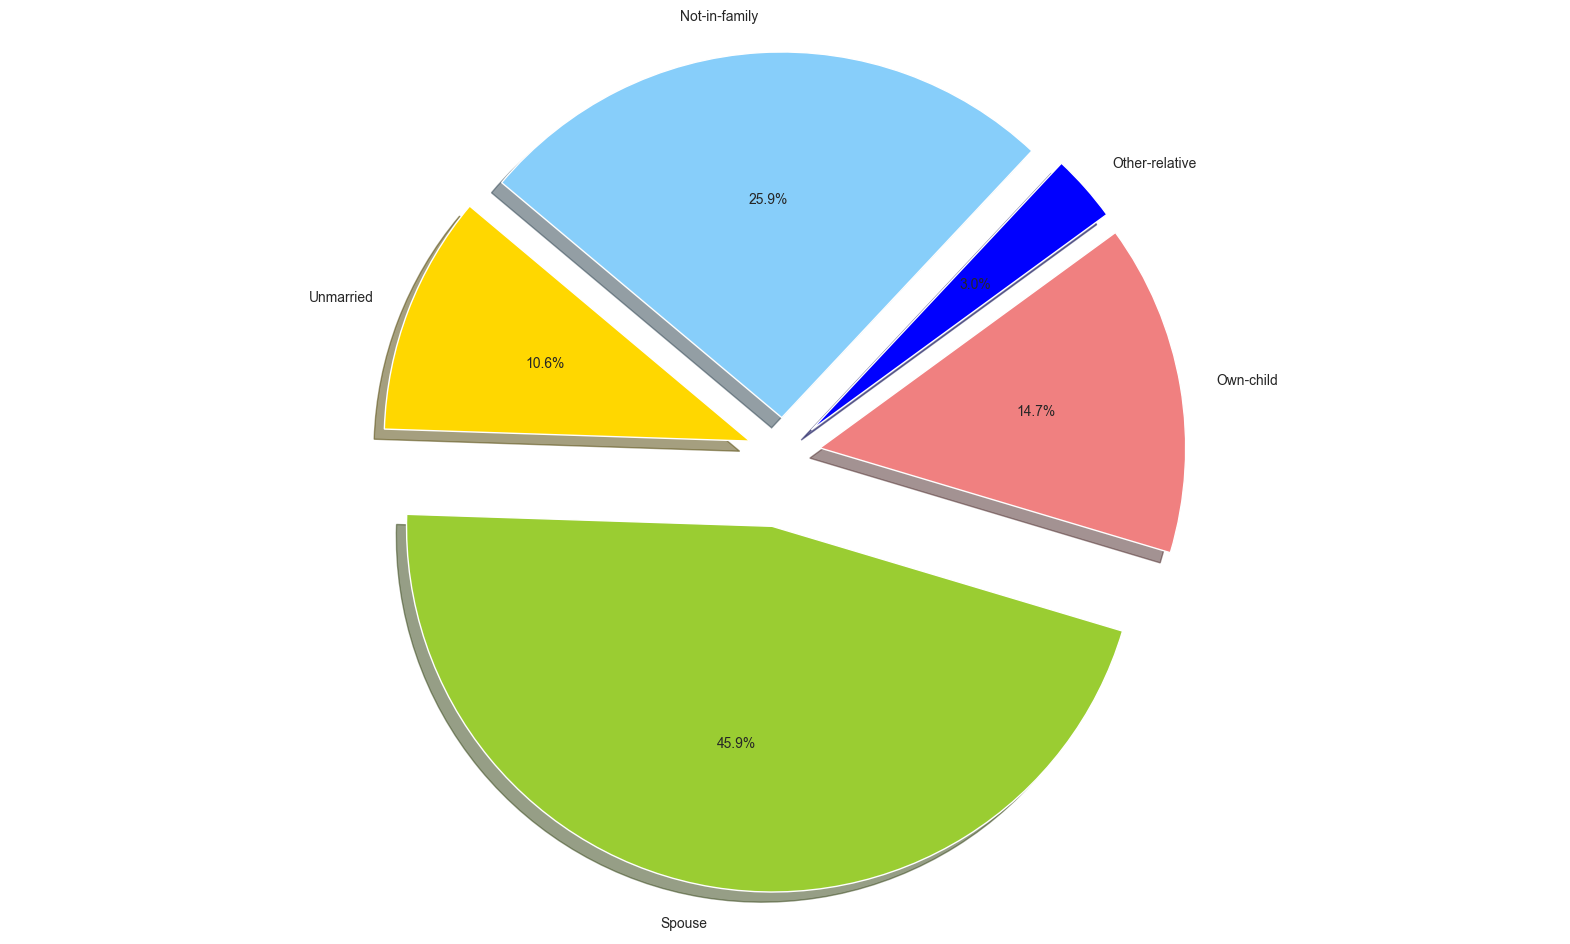

In [68]:
# in the `relationship` column, `Husband` and `Wife` values are similar which can be combined into a single value named `Spouse`
def combine_similar_values_in_relationship(row_value: str) -> str:
    if row_value in ("Husband", "Wife"):
        return "Spouse"

    return row_value


df = df.withColumn(
        "relationship", F.udf(lambda row: combine_similar_values_in_relationship(row))(F.col("relationship"))
)
show_pie_chart(df, "relationship")

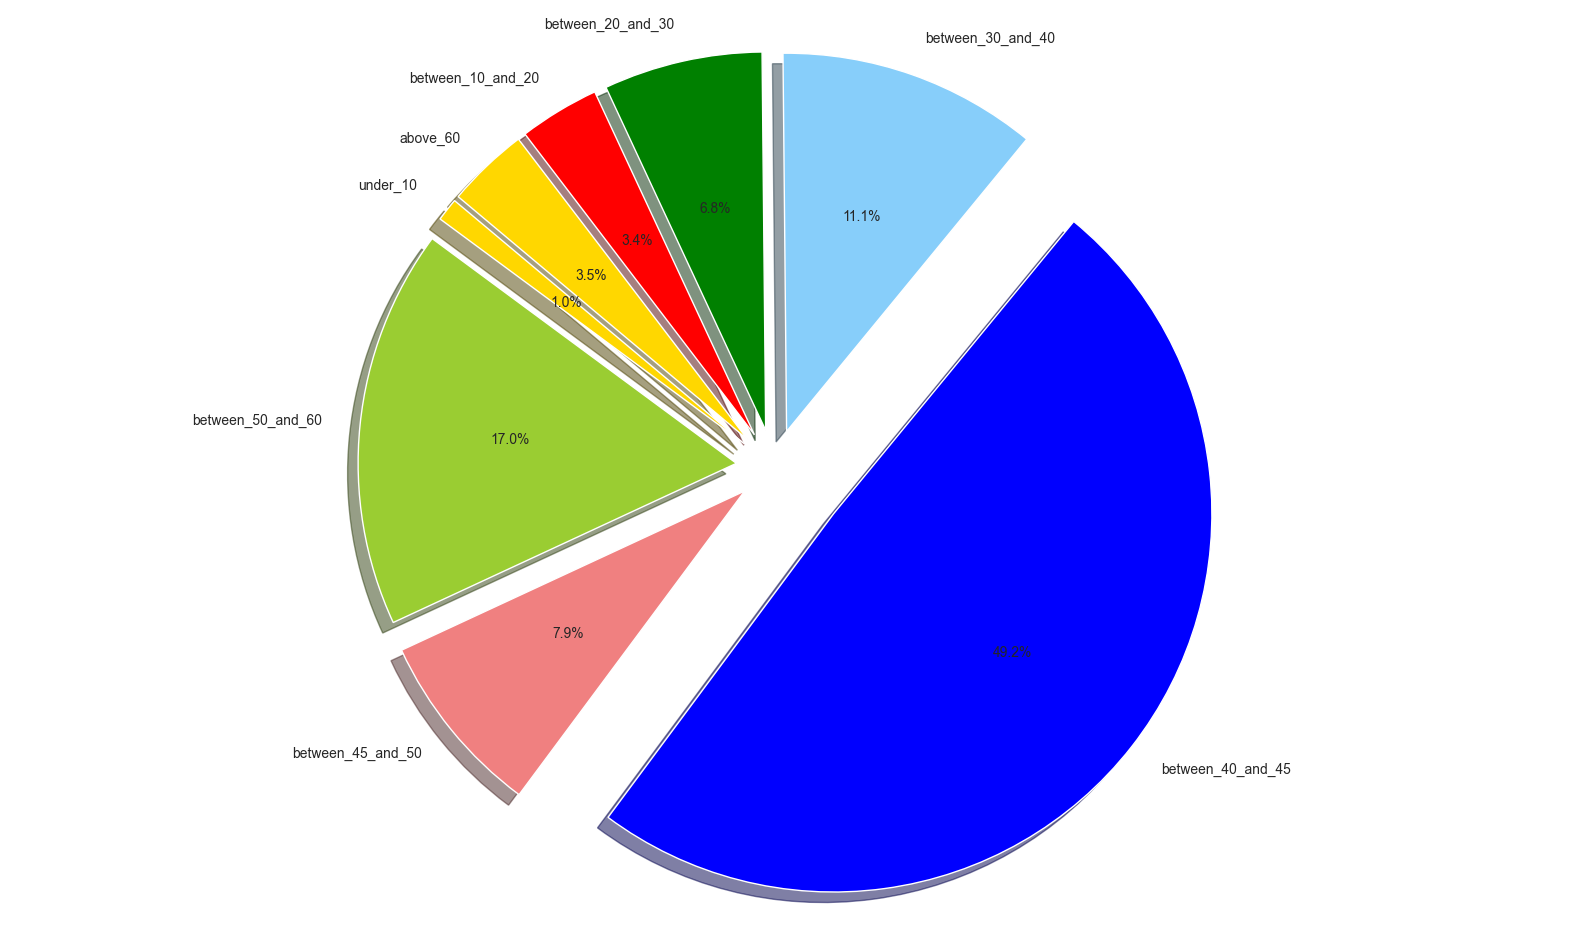

In [69]:
# categorize `hours_per_week` column
def categorize_hours_per_week_column(row_value: int) -> str:
    if row_value < 10:
        return "under_10"
    elif 10 <= row_value < 20:
        return "between_10_and_20"
    elif 20 <= row_value < 30:
        return "between_20_and_30"
    elif 30 <= row_value < 40:
        return "between_30_and_40"
    elif 40 <= row_value < 45:
        return "between_40_and_45"
    elif 45 <= row_value < 50:
        return "between_45_and_50"
    elif 50 <= row_value <= 60:
        return "between_50_and_60"
    else:
        return "above_60"


df = df.withColumn(
        "hours_per_week_cat",
        F.udf(lambda row_value: categorize_hours_per_week_column(row_value))(F.col("hours_per_week"))
)
show_pie_chart(df, "hours_per_week_cat")

# drop the `hours_per_week` column, it is not required anymore
df = df.drop("hours_per_week")

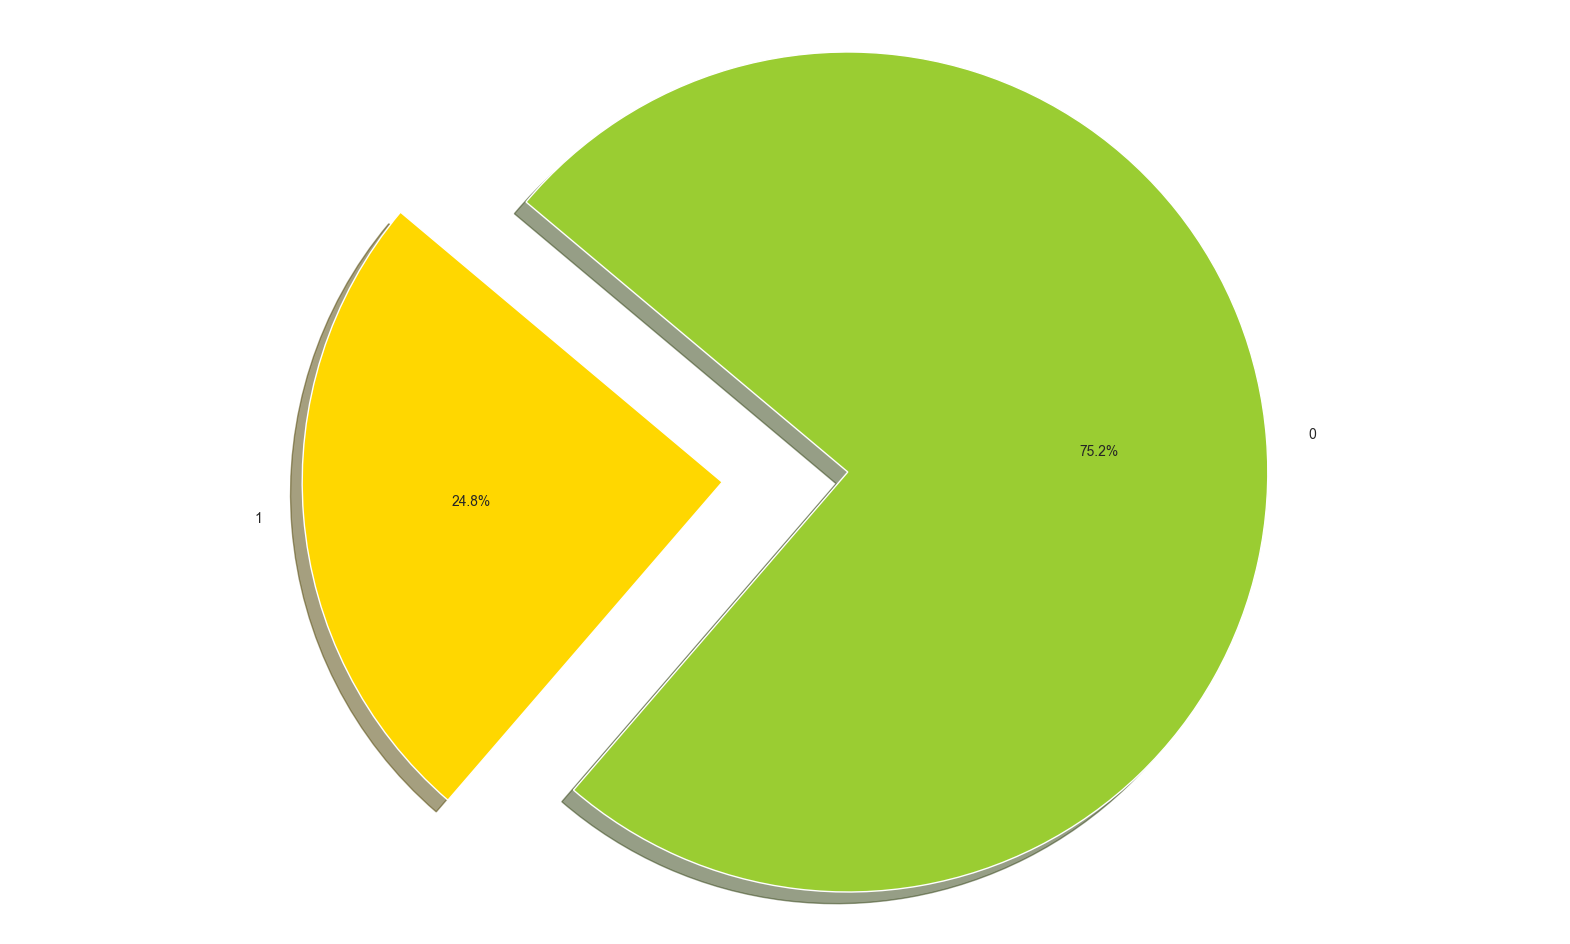

In [70]:
# convert the `income` column from categorical to numerical
def convert_income_column(row_value: str) -> int:
    if row_value in (">50K", ">50K."):
        return 1
    else:
        return 0


df = df.withColumn("income", F.udf(lambda row: convert_income_column(row))(F.col("income")).cast("int"))
show_pie_chart(df, "income")

In [71]:
df.printSchema()

root
 |-- workclass: string (nullable = true)
 |-- education: string (nullable = true)
 |-- marital_status: string (nullable = true)
 |-- occupation: string (nullable = true)
 |-- relationship: string (nullable = true)
 |-- race: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- native_country: string (nullable = true)
 |-- income: integer (nullable = true)
 |-- is_train: integer (nullable = false)
 |-- age_cat: string (nullable = true)
 |-- capital: double (nullable = true)
 |-- hours_per_week_cat: string (nullable = true)



In [72]:
numerical_columns = ["capital"]
categorical_columns = ["workclass", "education", "marital_status", "occupation", "relationship", "race", "sex",
                       "native_country", "age_cat", "hours_per_week_cat", ]
target_label = "income"

---
# 4. Train the ML Model

In [73]:
all_model_metrics_dict = defaultdict(dict)

In [74]:
class PipelineWrapper:
    def __init__(
            self,
            model,
            categorical_columns_: List[str],
            numerical_columns_: List[str],
            label_col: str,
            scaler: str = "standardize",
    ):
        self.model = model
        self.categorical_columns = categorical_columns_
        self.numerical_columns = numerical_columns_
        self.label_col = label_col
        self.scaler = scaler
        self.pipeline = None

        indexers = [
            StringIndexer(
                    inputCol=c,
                    outputCol=c + "_indexed",
                    handleInvalid="skip",
            )
            for c in self.categorical_columns
        ]

        encoders = [
            OneHotEncoder(
                    inputCol=indexer.getOutputCol(),
                    outputCol=indexer.getOutputCol() + "_encoded",
            )
            for indexer in indexers
        ]

        assembler = VectorAssembler(
                inputCols=[encoder.getOutputCol() for encoder in encoders]
                          + self.numerical_columns,
                outputCol="features",
        )

        stages = indexers + encoders + [assembler]

        if self.scaler == "standardize":
            scaler = StandardScaler(
                    inputCol="features",
                    outputCol="scaled_features",
                    withStd=True,
                    withMean=True,
            )
            stages += [scaler]
        elif self.scaler == "normalize":
            scaler = Normalizer(inputCol="features", outputCol="scaled_features")
            stages += [scaler]
        else:
            pass

        stages += [self.model]

        self.pipeline = Pipeline(stages=stages)

In [75]:
def show_model_parameters_mappings(model) -> None:
    print(
            list(
                    zip(
                            model.getEstimatorParamMaps(),
                            model.avgMetrics,
                    )
            )
    )

In [76]:
def show_model_performance_summary(
        model_name: str,
        is_train_mode: bool,
        evaluator: BinaryClassificationEvaluator,
        prediction_dataframe: pyspark.sql.DataFrame,
        label_col: str = "label",
) -> None:
    area_under_roc = evaluator.evaluate(
            prediction_dataframe, {evaluator.metricName: "areaUnderROC"}
    )
    area_under_pr = evaluator.evaluate(
            prediction_dataframe, {evaluator.metricName: "areaUnderPR"}
    )

    # compute TN, TP, FN, and FP metrics
    prediction_dataframe.groupBy(label_col, "prediction").count().show()

    # Calculate the elements of the confusion matrix
    TN = prediction_dataframe.filter(
            f"prediction = 0 AND {label_col} = prediction"
    ).count()
    TP = prediction_dataframe.filter(
            f"prediction = 1 AND {label_col} = prediction"
    ).count()
    FN = prediction_dataframe.filter(
            f"prediction = 0 AND {label_col} <> prediction"
    ).count()
    FP = prediction_dataframe.filter(
            f"prediction = 1 AND {label_col} <> prediction"
    ).count()

    # calculate accuracy, precision, recall, and F1-score
    accuracy = (TN + TP) / (TN + TP + FN + FP)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1_score = 2 * (precision * recall) / (precision + recall)

    all_model_metrics_dict[model_name]["train" if is_train_mode else "test"] = {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1_score,
    }

    print("Model Performance Summary:")

    print(f"Area Under ROC: {area_under_roc}")
    print(f"Area Under PR: {area_under_pr}")

    print(f"Accuracy: {accuracy:.3f}")
    print(f"Precision: {precision:.3f}")
    print(f"Recall: {recall:.3f}")
    print(f"F1 score: {f1_score:.3f}")

In [77]:
# split the dataframe into training and testing sets
train_df = df.filter(F.col("is_train") == 1).drop("is_train")
test_df = df.filter(F.col("is_train") == 0).drop("is_train")

## Decision Tree Classifier

In [78]:
decision_tree_model = DecisionTreeClassifier(labelCol=target_label)
decision_tree_param_grid = (
    ParamGridBuilder()
    .addGrid(decision_tree_model.maxDepth, [2, 4, 6, 8, 10])
    .addGrid(decision_tree_model.maxBins, [10, 50, 100, 150])
    .build()
)
decision_tree_pipeline_wrapper = PipelineWrapper(
        model=decision_tree_model,
        categorical_columns_=categorical_columns,
        numerical_columns_=numerical_columns,
        label_col=target_label,
)

decision_tree_evaluator = BinaryClassificationEvaluator(labelCol=target_label)

decision_tree_cv = CrossValidator(
        estimator=decision_tree_pipeline_wrapper.pipeline,
        evaluator=decision_tree_evaluator,
        estimatorParamMaps=decision_tree_param_grid,
        numFolds=3,
        seed=1,
)
decision_tree_cv_model = decision_tree_cv.fit(train_df)

In [79]:
decision_tree_train_prediction = decision_tree_cv_model.bestModel.transform(train_df)
show_model_performance_summary(
        "decision_tree",
        True,
        decision_tree_evaluator,
        decision_tree_train_prediction,
        label_col=target_label,
)

+------+----------+-----+
|income|prediction|count|
+------+----------+-----+
|     1|       0.0| 6238|
|     0|       0.0|22242|
|     1|       1.0| 1270|
|     0|       1.0|  412|
+------+----------+-----+

Model Performance Summary:
Area Under ROC: 0.7387016545818947
Area Under PR: 0.412423073092689
Accuracy: 0.780
Precision: 0.755
Recall: 0.169
F1 score: 0.276


In [80]:
decision_tree_test_prediction = decision_tree_cv_model.bestModel.transform(test_df)
show_model_performance_summary(
        "decision_tree",
        False,
        decision_tree_evaluator,
        decision_tree_test_prediction,
        label_col=target_label,
)

+------+----------+-----+
|income|prediction|count|
+------+----------+-----+
|     1|       0.0| 3085|
|     0|       0.0|11172|
|     1|       1.0|  615|
|     0|       1.0|  188|
+------+----------+-----+

Model Performance Summary:
Area Under ROC: 0.7408489960030454
Area Under PR: 0.41030557775027826
Accuracy: 0.783
Precision: 0.766
Recall: 0.166
F1 score: 0.273


## Random Forest Classifier

In [81]:
random_forest_model = RandomForestClassifier(labelCol=target_label)
random_forest_param_grid = (
    ParamGridBuilder()
    .addGrid(random_forest_model.maxDepth, [2, 4, 6, 8, 10])
    .addGrid(random_forest_model.maxBins, [10, 50, 100, 150])
    .build()
)
random_forest_pipeline_wrapper = PipelineWrapper(
        model=random_forest_model,
        categorical_columns_=categorical_columns,
        numerical_columns_=numerical_columns,
        label_col=target_label,
)

random_forest_evaluator = BinaryClassificationEvaluator(labelCol=target_label)

random_forest_cv = CrossValidator(
        estimator=random_forest_pipeline_wrapper.pipeline,
        evaluator=random_forest_evaluator,
        estimatorParamMaps=random_forest_param_grid,
        numFolds=3,
        seed=1,
)
random_forest_cv_model = random_forest_cv.fit(train_df)

In [82]:
random_forest_train_prediction = random_forest_cv_model.bestModel.transform(train_df)
show_model_performance_summary(
        "random_forest",
        True,
        random_forest_evaluator,
        random_forest_train_prediction,
        label_col=target_label,
)

+------+----------+-----+
|income|prediction|count|
+------+----------+-----+
|     1|       0.0| 3231|
|     0|       0.0|21559|
|     1|       1.0| 4277|
|     0|       1.0| 1095|
+------+----------+-----+



Model Performance Summary:
Area Under ROC: 0.9124342968571383
Area Under PR: 0.803361405604529
Accuracy: 0.857
Precision: 0.796
Recall: 0.570
F1 score: 0.664


In [83]:
random_forest_test_prediction = random_forest_cv_model.bestModel.transform(test_df)
show_model_performance_summary(
        "random_forest",
        False,
        random_forest_evaluator,
        random_forest_test_prediction,
        label_col=target_label,
)

+------+----------+-----+
|income|prediction|count|
+------+----------+-----+
|     1|       0.0| 1630|
|     0|       0.0|10792|
|     1|       1.0| 2070|
|     0|       1.0|  568|
+------+----------+-----+

Model Performance Summary:
Area Under ROC: 0.9010602398172819
Area Under PR: 0.7792814165762082
Accuracy: 0.854
Precision: 0.785
Recall: 0.559
F1 score: 0.653


## Linear SVC Model

In [84]:
linear_svc_model = LinearSVC(labelCol=target_label)
linear_svc_param_grid = (
    ParamGridBuilder().addGrid(linear_svc_model.maxIter, [50, 100, 500, 1000]).build()
)
linear_svc_pipeline_wrapper = PipelineWrapper(
        model=linear_svc_model,
        categorical_columns_=categorical_columns,
        numerical_columns_=numerical_columns,
        label_col=target_label,
)

linear_svc_evaluator = BinaryClassificationEvaluator(labelCol=target_label)

linear_svc_cv = CrossValidator(
        estimator=linear_svc_pipeline_wrapper.pipeline,
        evaluator=linear_svc_evaluator,
        estimatorParamMaps=linear_svc_param_grid,
        numFolds=3,
        seed=42,
)
linear_svc_cv_model = linear_svc_cv.fit(train_df)

In [85]:
linear_svc_train_prediction = linear_svc_cv_model.bestModel.transform(train_df)
show_model_performance_summary(
        "linear_svc",
        True,
        linear_svc_evaluator,
        linear_svc_train_prediction,
        label_col=target_label,
)

+------+----------+-----+
|income|prediction|count|
+------+----------+-----+
|     1|       0.0| 3045|
|     0|       0.0|21084|
|     1|       1.0| 4463|
|     0|       1.0| 1570|
+------+----------+-----+

Model Performance Summary:
Area Under ROC: 0.898683986367575
Area Under PR: 0.7605053309013412
Accuracy: 0.847
Precision: 0.740
Recall: 0.594
F1 score: 0.659


In [86]:
linear_svc_test_prediction = linear_svc_cv_model.bestModel.transform(test_df)
show_model_performance_summary(
        "linear_svc",
        False,
        linear_svc_evaluator,
        linear_svc_test_prediction,
        label_col=target_label,
)

+------+----------+-----+
|income|prediction|count|
+------+----------+-----+
|     1|       0.0| 1511|
|     0|       0.0|10549|
|     1|       1.0| 2189|
|     0|       1.0|  811|
+------+----------+-----+

Model Performance Summary:
Area Under ROC: 0.8971925556718697
Area Under PR: 0.7544792856049178
Accuracy: 0.846
Precision: 0.730
Recall: 0.592
F1 score: 0.653


In [87]:
show_model_parameters_mappings(linear_svc_cv_model)

[({Param(parent='LinearSVC_11645271aaba', name='maxIter', doc='max number of iterations (>= 0).'): 50}, 0.8976770695454542), ({Param(parent='LinearSVC_11645271aaba', name='maxIter', doc='max number of iterations (>= 0).'): 100}, 0.8976109007280891), ({Param(parent='LinearSVC_11645271aaba', name='maxIter', doc='max number of iterations (>= 0).'): 500}, 0.8975913196333747), ({Param(parent='LinearSVC_11645271aaba', name='maxIter', doc='max number of iterations (>= 0).'): 1000}, 0.8975913196333747)]


## Logistic Regression Model

In [88]:
linear_regression_model = LogisticRegression(labelCol=target_label)

linear_regression_param_grid = (
    ParamGridBuilder()
    .addGrid(linear_regression_model.threshold, [0.4, 0.5, 0.6])
    .addGrid(linear_regression_model.maxIter, [50, 100, 500, 1000])
    .build()
)
linear_regression_pipeline_wrapper = PipelineWrapper(
        model=linear_regression_model,
        categorical_columns_=categorical_columns,
        numerical_columns_=numerical_columns,
        label_col=target_label,
)

linear_regression_evaluator = BinaryClassificationEvaluator(labelCol=target_label)

linear_regression_cv = CrossValidator(
        estimator=linear_regression_pipeline_wrapper.pipeline,
        evaluator=linear_regression_evaluator,
        estimatorParamMaps=linear_regression_param_grid,
        numFolds=3,
        seed=1,
)
linear_regression_cv_model = linear_regression_cv.fit(train_df)

In [89]:
lr_train_prediction = linear_regression_cv_model.bestModel.transform(train_df)
show_model_performance_summary(
        "logistic_regression",
        True,
        linear_regression_evaluator,
        lr_train_prediction,
        target_label,
)

+------+----------+-----+
|income|prediction|count|
+------+----------+-----+
|     1|       0.0| 2253|
|     0|       0.0|20149|
|     1|       1.0| 5255|
|     0|       1.0| 2505|
+------+----------+-----+

Model Performance Summary:
Area Under ROC: 0.9028489295947252
Area Under PR: 0.7653612723438373
Accuracy: 0.842
Precision: 0.677
Recall: 0.700
F1 score: 0.688


In [90]:
lr_test_prediction = linear_regression_cv_model.bestModel.transform(test_df)
show_model_performance_summary(
        "logistic_regression",
        False,
        linear_regression_evaluator,
        lr_test_prediction,
        target_label,
)

+------+----------+-----+
|income|prediction|count|
+------+----------+-----+
|     1|       0.0| 1128|
|     0|       0.0|10062|
|     1|       1.0| 2572|
|     0|       1.0| 1298|
+------+----------+-----+

Model Performance Summary:
Area Under ROC: 0.9002309311952799
Area Under PR: 0.7577997979929432
Accuracy: 0.839
Precision: 0.665
Recall: 0.695
F1 score: 0.680


## Gradient-Boosted Trees Classifier

In [92]:
gbt_model = GBTClassifier(labelCol=target_label)

gbt_param_grid = (
    ParamGridBuilder()
    .addGrid(gbt_model.maxDepth, [2, 4, 6, 8, 10])
    .addGrid(gbt_model.maxBins, [10, 50, 100, 150])
    .build()
)
gbt_pipeline_wrapper = PipelineWrapper(
        model=gbt_model,
        categorical_columns_=categorical_columns,
        numerical_columns_=numerical_columns,
        label_col=target_label,
)

gbt_evaluator = BinaryClassificationEvaluator(labelCol=target_label)

gbt_cv = CrossValidator(
        estimator=gbt_pipeline_wrapper.pipeline,
        evaluator=gbt_evaluator,
        estimatorParamMaps=gbt_param_grid,
        numFolds=3,
        seed=1,
)
gbt_cv_model = gbt_cv.fit(train_df)

In [93]:
gbt_train_prediction = gbt_cv_model.bestModel.transform(train_df)
show_model_performance_summary(
        "gbt",
        True,
        gbt_evaluator,
        gbt_train_prediction,
        target_label,
)

+------+----------+-----+
|income|prediction|count|
+------+----------+-----+
|     1|       0.0| 2613|
|     0|       0.0|21518|
|     1|       1.0| 4895|
|     0|       1.0| 1136|
+------+----------+-----+



Model Performance Summary:
Area Under ROC: 0.933765253262828
Area Under PR: 0.8461350963035376
Accuracy: 0.876
Precision: 0.812
Recall: 0.652
F1 score: 0.723


In [94]:
gbt_test_prediction = gbt_cv_model.bestModel.transform(test_df)
show_model_performance_summary(
        "gbt",
        False,
        gbt_evaluator,
        gbt_test_prediction,
        target_label,
)

+------+----------+-----+
|income|prediction|count|
+------+----------+-----+
|     1|       0.0| 1425|
|     0|       0.0|10676|
|     1|       1.0| 2275|
|     0|       1.0|  684|
+------+----------+-----+

Model Performance Summary:
Area Under ROC: 0.9109868195660447
Area Under PR: 0.7961480013840092
Accuracy: 0.860
Precision: 0.769
Recall: 0.615
F1 score: 0.683
